In [1]:
from google.colab import output
!python -m pip install datasets
!pip install --upgrade --no-cache-dir gdown
!gdown 1W3eo0VQXxcSjY8kx4IgHGlopd6OK69pp
!unzip probing.zip

!gdown 1PFSpW14aXO-sMNzT_jIjZPfNhk3u3ULD
!unzip probing_numbers.zip

output.clear()

In [3]:
import gc
import random
import numpy as np
import pickle
from functools import partial
from datasets import load_from_disk
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

SEED = 8
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
def prepare_embeds(task_embed):
    X = {'train':  torch.tensor(task_embed['train']['X']),
     'valid':  torch.tensor(task_embed['dev']['X']),
     'test':  torch.tensor(task_embed['test']['X'])}
    y = {'train':  torch.tensor(task_embed['train']['y']),
        'valid':  torch.tensor(task_embed['dev']['y']),
        'test':  torch.tensor(task_embed['test']['y'])}
    sc = StandardScaler()
    X['train'] = torch.tensor(sc.fit_transform(X['train']), dtype=torch.float)
    X['valid'] = torch.tensor(sc.transform(X['valid']), dtype=torch.float)
    X['test'] = torch.tensor(sc.transform(X['test']), dtype=torch.float)
    return X, y


def run_model(task_name, dimensions_name, dimensions, nclasses, num_epochs, lr, train_dataloader, val_dataloader, val_size, test_dataloader, test_size):
    model = torch.nn.Linear(len(dimensions), nclasses).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    acs = []
    val_loss = []
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_dataloader:
            y_pred = model(X_batch[:, dimensions].to(device))
            loss = criterion(y_pred, y_batch.to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        gc.collect()
        current_accuracy = 0
        current_loss = 0


        for X_batch, y_batch in val_dataloader:
            y_pred = model(X_batch[:, dimensions].to(device))
            loss = criterion(y_pred, y_batch.to(device))
            current_loss += loss.item()
            current_accuracy += (y_pred.to('cpu').argmax(dim=1) == y_batch).sum().item()

        acs.append(current_accuracy / val_size)
        val_loss.append(current_loss / val_size)
        if epoch % 20 == 0:
            print(f'epoch: {epoch+1}, Validation accuracy = {acs[-1]:.4f}')
        if len(val_loss) > 10 and val_loss[-1] >= val_loss[-2] and val_loss[-1] >= val_loss[-10]:
            break

    test_accuracy = 0
    test_loss = 0
    for X_batch, y_batch in test_dataloader:
        y_pred = model(X_batch[:, dimensions].to(device))
        test_accuracy += (y_pred.to('cpu').argmax(dim=1) == y_batch).sum().item()

    print("Test accuracy {}, on {} dimensions:".format(task_name, dimensions_name), test_accuracy / test_size)
    plt.plot(acs)
    plt.show()
    plt.plot(val_loss)
    plt.show()
    return test_accuracy / test_size



def get_accuracies(task_name, num_epochs, batch_size, lr, outlier_dimensions, random_repetitions=5):
    task_embed = load_from_disk("{}.hf".format(task_name))
    labels = sorted(np.unique(task_embed['train']['y']))
    nclasses = len(dict(zip(labels, range(len(labels)))))
    X, y = prepare_embeds(task_embed)
    train_dataset = torch.utils.data.TensorDataset(X['train'], y['train'])
    val_dataset = torch.utils.data.TensorDataset(X['valid'], y['valid'])
    test_dataset = torch.utils.data.TensorDataset(X['test'], y['test'])
    emb_size = X['test'].shape[1]


    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    all_dimensions = list(range(X['train'].shape[1]))
    all_acc = run_model(task_name=task_name, dimensions_name="all", dimensions=all_dimensions,
                        nclasses=nclasses, num_epochs=num_epochs, lr=lr,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader, val_size=len(val_dataset),
                        test_dataloader=test_dataloader, test_size=len(test_dataset))

    outlier_acc = run_model(task_name=task_name, dimensions_name="outlier", dimensions=outlier_dimensions,
                            nclasses=nclasses, num_epochs=num_epochs, lr=lr,
                            train_dataloader=train_dataloader,
                            val_dataloader=val_dataloader, val_size=len(val_dataset),
                            test_dataloader=test_dataloader, test_size=len(test_dataset))

    random_accs = []
    for i in range(random_repetitions):
        random_dimensions = np.random.choice(emb_size, len(outlier_dimensions), replace='False')
        random_accs.append(run_model(task_name=task_name, dimensions_name="random", dimensions=random_dimensions,
                                     nclasses=nclasses, num_epochs=num_epochs, lr=lr,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader, val_size=len(val_dataset),
                                     test_dataloader=test_dataloader, test_size=len(test_dataset)))

    random_acc = float(np.mean(random_accs))
    gc.collect()
    return all_acc, outlier_acc, random_acc

In [5]:
transfer_tasks = [
    'Length',
    'Depth',
    'TopConstituents',
    'BigramShift',
    'Tense',
    'SubjNumber', 'ObjNumber',
    'OddManOut',
    'CoordinationInversion',
    'WordContent',
    ]

num_epochs = 200
batch_size = 2048
lr = 0.01
outlier_dimensions = [61, 77, 82, 97, 217, 219, 240, 330, 361, 453, 494, 496, 498, 551, 588, 731, 749]

In [6]:
all_accuracy, outlier_accuracy, random_accuracy = dict(), dict(), dict()

epoch: 1, Validation accuracy = 0.3947
epoch: 21, Validation accuracy = 0.6325
epoch: 41, Validation accuracy = 0.6917
epoch: 61, Validation accuracy = 0.7225
epoch: 81, Validation accuracy = 0.7404
epoch: 101, Validation accuracy = 0.7505
epoch: 121, Validation accuracy = 0.7591
epoch: 141, Validation accuracy = 0.7665
epoch: 161, Validation accuracy = 0.7725
epoch: 181, Validation accuracy = 0.7782
Test accuracy Length, on all dimensions: 0.7732092837134854


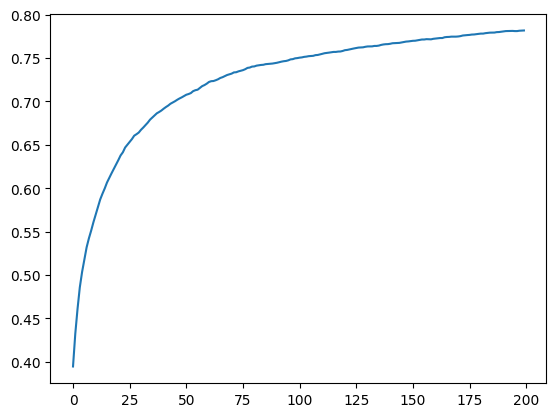

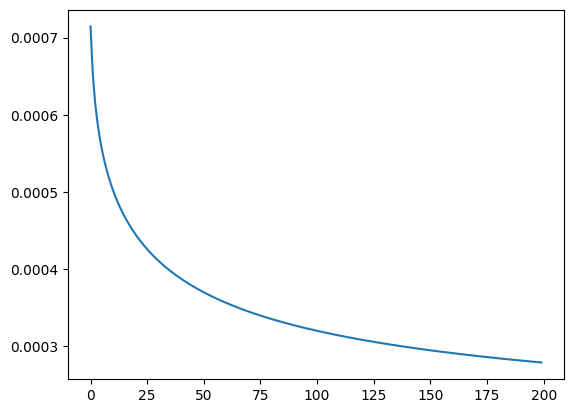

epoch: 1, Validation accuracy = 0.3447
epoch: 21, Validation accuracy = 0.5103
epoch: 41, Validation accuracy = 0.5717
epoch: 61, Validation accuracy = 0.6041
epoch: 81, Validation accuracy = 0.6244
epoch: 101, Validation accuracy = 0.6374
epoch: 121, Validation accuracy = 0.6493
epoch: 141, Validation accuracy = 0.6577
epoch: 161, Validation accuracy = 0.6635
epoch: 181, Validation accuracy = 0.6680
Test accuracy Length, on outlier dimensions: 0.6591636654661864


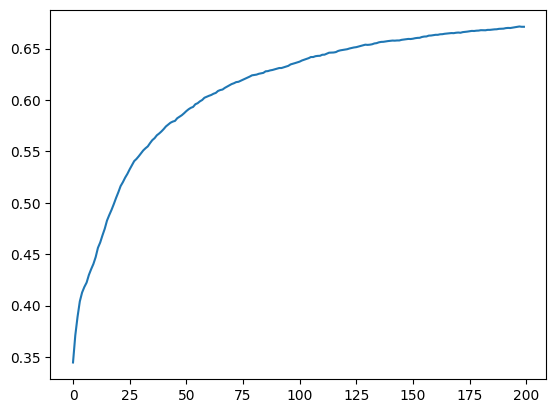

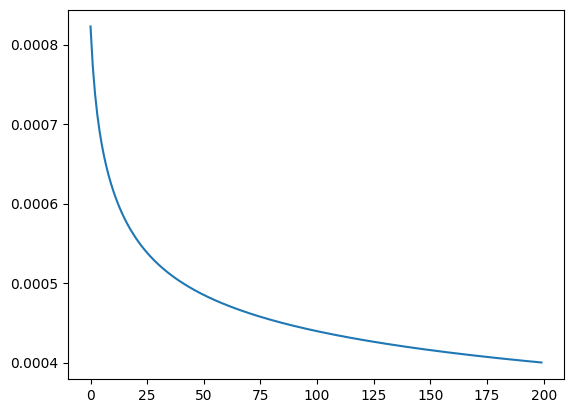

epoch: 1, Validation accuracy = 0.1630
epoch: 21, Validation accuracy = 0.2599
epoch: 41, Validation accuracy = 0.2690
epoch: 61, Validation accuracy = 0.2692
epoch: 81, Validation accuracy = 0.2691
Test accuracy Length, on random dimensions: 0.281312525010004


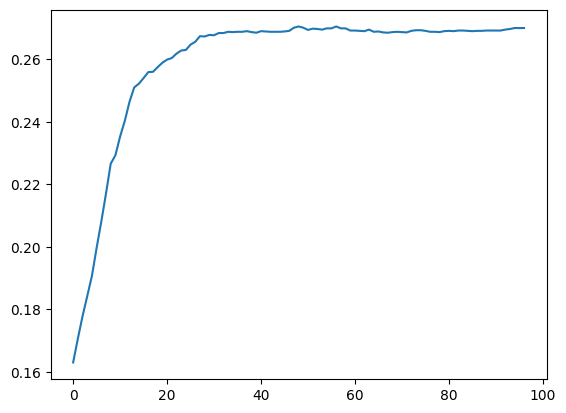

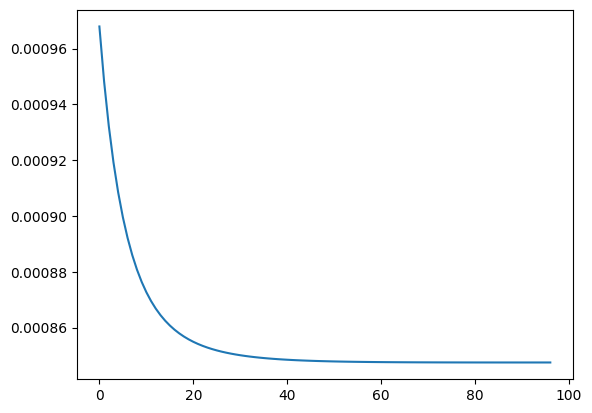

epoch: 1, Validation accuracy = 0.1967
epoch: 21, Validation accuracy = 0.3423
epoch: 41, Validation accuracy = 0.3521
epoch: 61, Validation accuracy = 0.3555
epoch: 81, Validation accuracy = 0.3597
epoch: 101, Validation accuracy = 0.3607
epoch: 121, Validation accuracy = 0.3603
epoch: 141, Validation accuracy = 0.3612
epoch: 161, Validation accuracy = 0.3610
epoch: 181, Validation accuracy = 0.3610
Test accuracy Length, on random dimensions: 0.34883953581432575


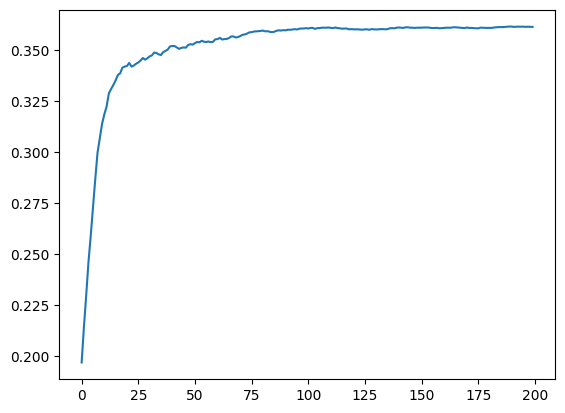

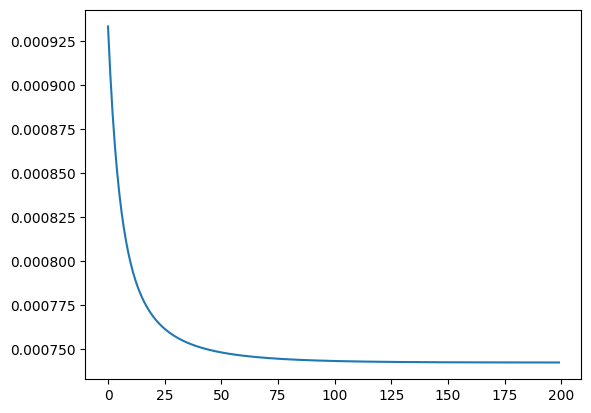

epoch: 1, Validation accuracy = 0.1673
epoch: 21, Validation accuracy = 0.2054
Test accuracy Length, on random dimensions: 0.22569027611044418


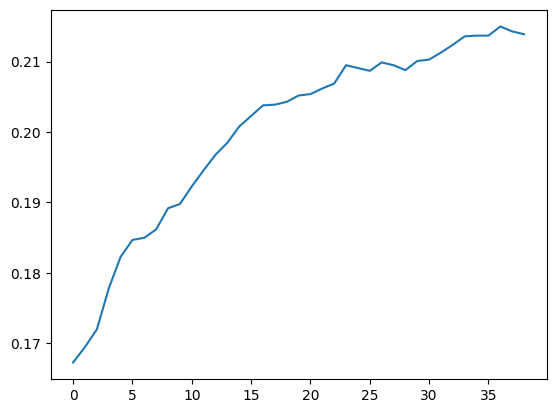

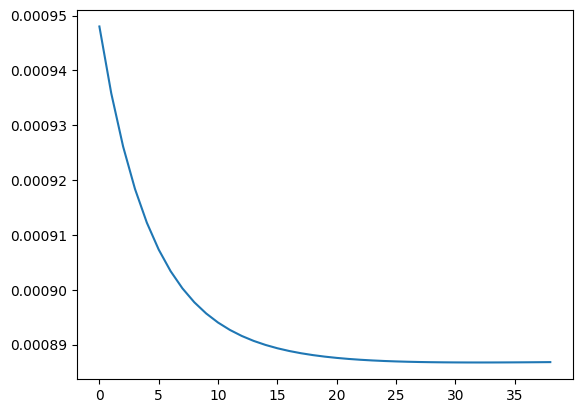

epoch: 1, Validation accuracy = 0.1925
epoch: 21, Validation accuracy = 0.3318
epoch: 41, Validation accuracy = 0.3509
epoch: 61, Validation accuracy = 0.3543
epoch: 81, Validation accuracy = 0.3569
epoch: 101, Validation accuracy = 0.3579
epoch: 121, Validation accuracy = 0.3577
epoch: 141, Validation accuracy = 0.3578
epoch: 161, Validation accuracy = 0.3582
epoch: 181, Validation accuracy = 0.3582
Test accuracy Length, on random dimensions: 0.3518407362945178


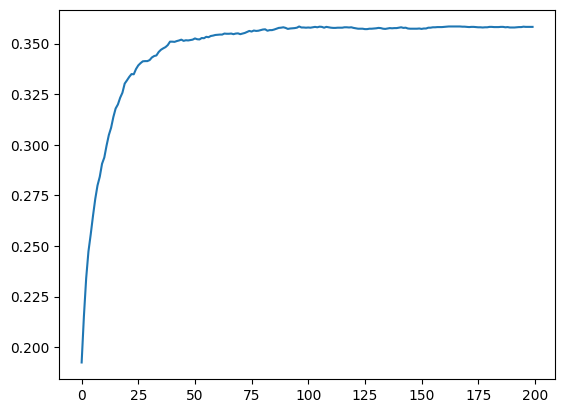

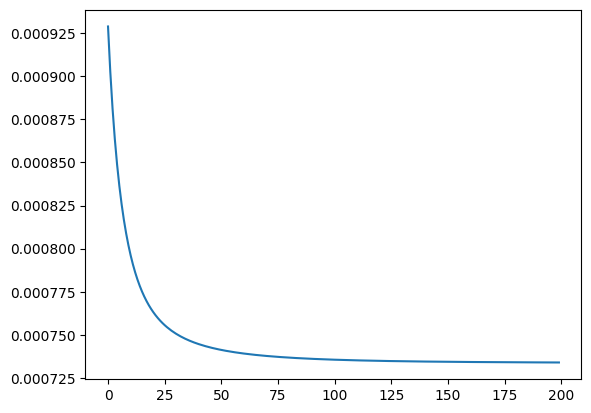

epoch: 1, Validation accuracy = 0.1908
epoch: 21, Validation accuracy = 0.2706
epoch: 41, Validation accuracy = 0.2719
epoch: 61, Validation accuracy = 0.2693
epoch: 81, Validation accuracy = 0.2684
Test accuracy Length, on random dimensions: 0.2974189675870348


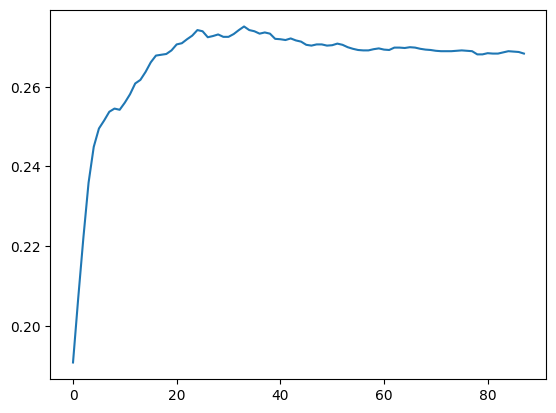

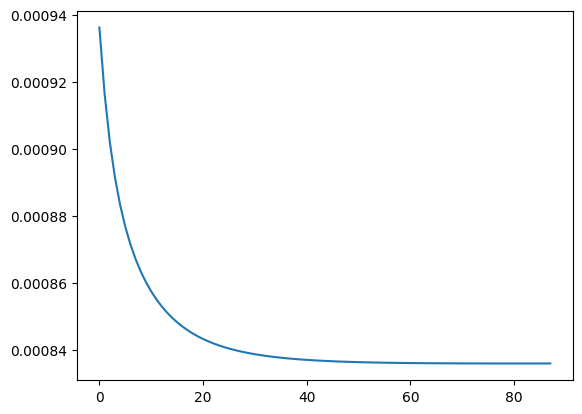

epoch: 1, Validation accuracy = 0.2255
epoch: 21, Validation accuracy = 0.3283
epoch: 41, Validation accuracy = 0.3530
epoch: 61, Validation accuracy = 0.3605
epoch: 81, Validation accuracy = 0.3639
epoch: 101, Validation accuracy = 0.3662
epoch: 121, Validation accuracy = 0.3712
epoch: 141, Validation accuracy = 0.3738
epoch: 161, Validation accuracy = 0.3766
epoch: 181, Validation accuracy = 0.3794
Test accuracy Depth, on all dimensions: 0.3826


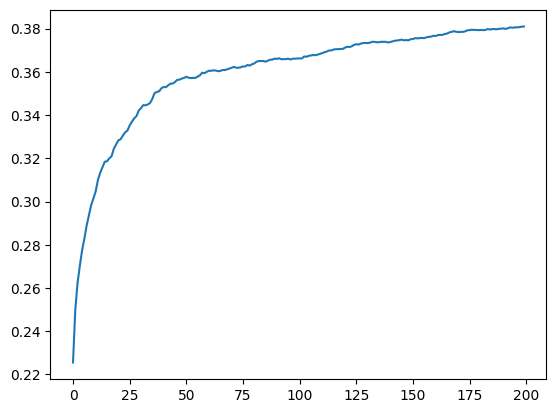

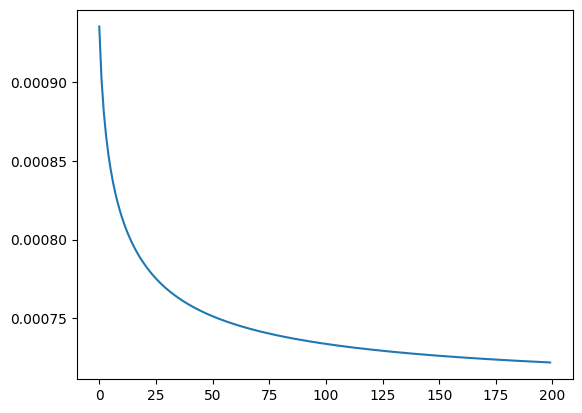

epoch: 1, Validation accuracy = 0.1458
epoch: 21, Validation accuracy = 0.2315
epoch: 41, Validation accuracy = 0.2482
epoch: 61, Validation accuracy = 0.2495
epoch: 81, Validation accuracy = 0.2525
epoch: 101, Validation accuracy = 0.2533
epoch: 121, Validation accuracy = 0.2530
epoch: 141, Validation accuracy = 0.2543
epoch: 161, Validation accuracy = 0.2535
epoch: 181, Validation accuracy = 0.2542
Test accuracy Depth, on outlier dimensions: 0.2502


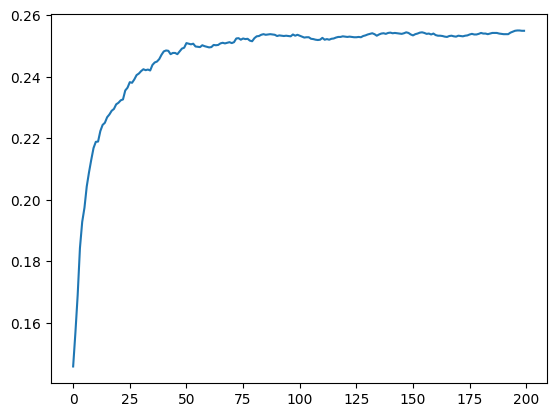

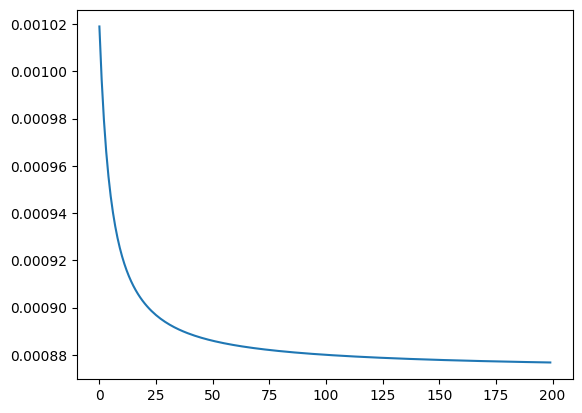

epoch: 1, Validation accuracy = 0.1484
epoch: 21, Validation accuracy = 0.2102
epoch: 41, Validation accuracy = 0.2137
epoch: 61, Validation accuracy = 0.2171
epoch: 81, Validation accuracy = 0.2183
epoch: 101, Validation accuracy = 0.2174
epoch: 121, Validation accuracy = 0.2177
epoch: 141, Validation accuracy = 0.2180
epoch: 161, Validation accuracy = 0.2178
Test accuracy Depth, on random dimensions: 0.2158


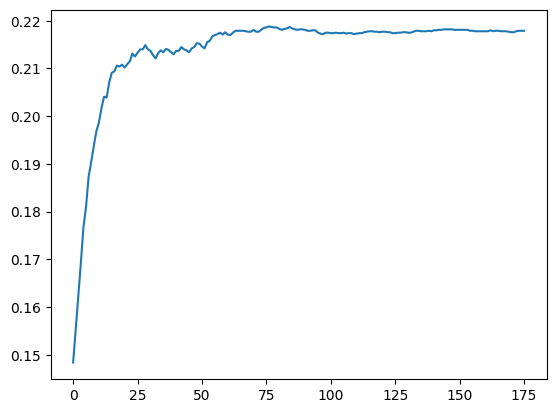

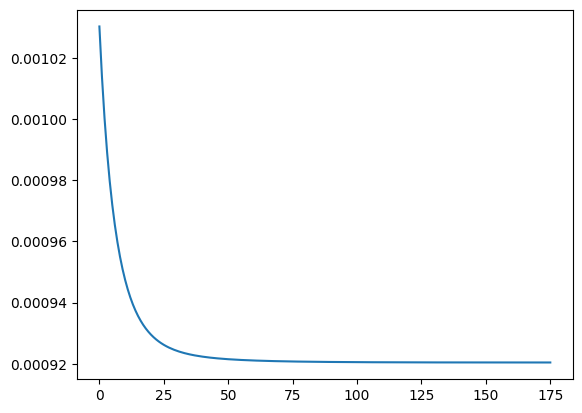

epoch: 1, Validation accuracy = 0.1524
epoch: 21, Validation accuracy = 0.2122
epoch: 41, Validation accuracy = 0.2252
epoch: 61, Validation accuracy = 0.2278
epoch: 81, Validation accuracy = 0.2306
epoch: 101, Validation accuracy = 0.2295
epoch: 121, Validation accuracy = 0.2303
epoch: 141, Validation accuracy = 0.2300
epoch: 161, Validation accuracy = 0.2299
epoch: 181, Validation accuracy = 0.2303
Test accuracy Depth, on random dimensions: 0.2181


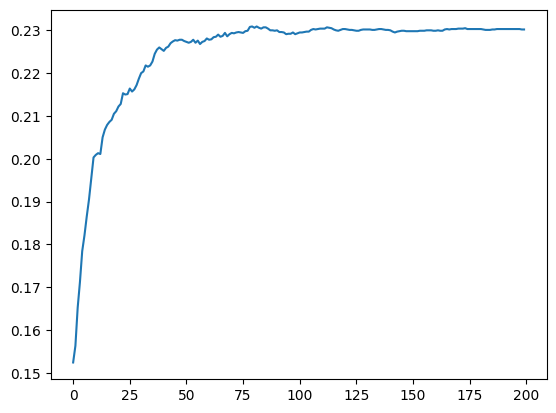

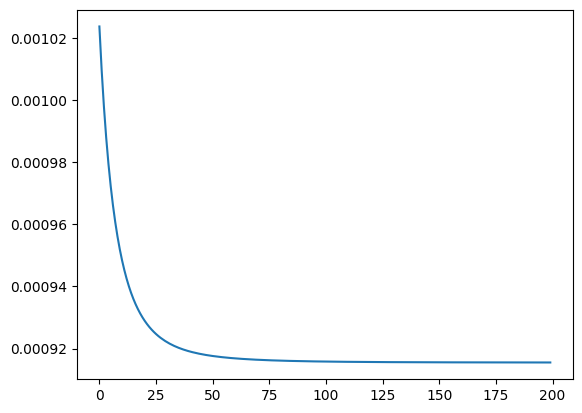

epoch: 1, Validation accuracy = 0.1433
epoch: 21, Validation accuracy = 0.2061
epoch: 41, Validation accuracy = 0.2163
epoch: 61, Validation accuracy = 0.2181
epoch: 81, Validation accuracy = 0.2184
epoch: 101, Validation accuracy = 0.2186
Test accuracy Depth, on random dimensions: 0.2179


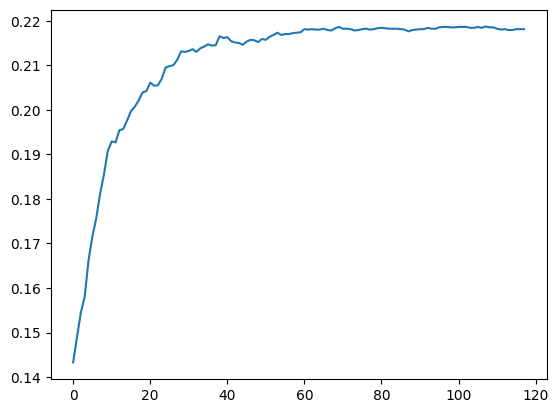

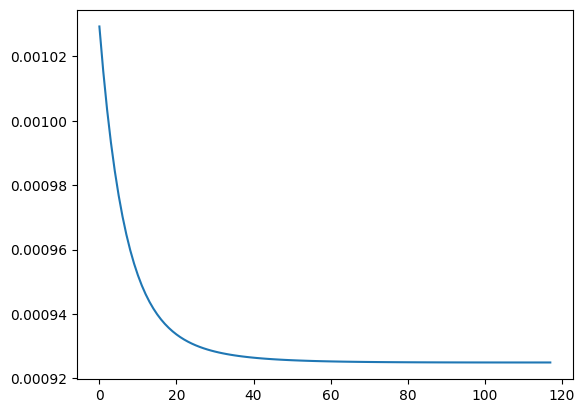

epoch: 1, Validation accuracy = 0.1381
epoch: 21, Validation accuracy = 0.1986
epoch: 41, Validation accuracy = 0.2066
epoch: 61, Validation accuracy = 0.2123
epoch: 81, Validation accuracy = 0.2103
epoch: 101, Validation accuracy = 0.2117
epoch: 121, Validation accuracy = 0.2125
epoch: 141, Validation accuracy = 0.2126
epoch: 161, Validation accuracy = 0.2126
epoch: 181, Validation accuracy = 0.2128
Test accuracy Depth, on random dimensions: 0.2184


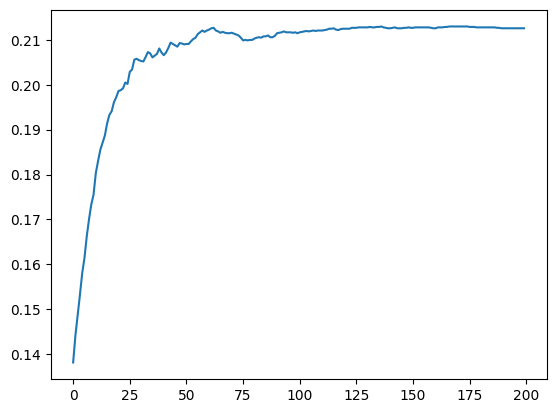

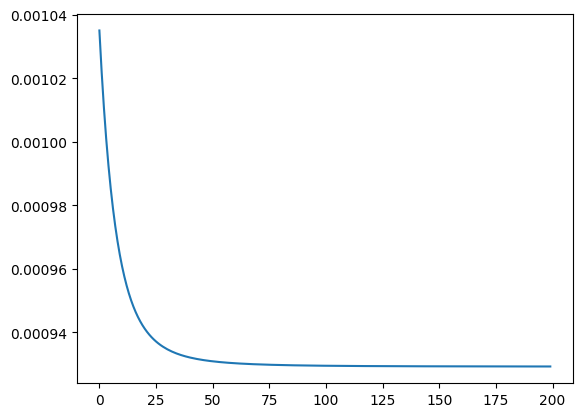

epoch: 1, Validation accuracy = 0.1515
epoch: 21, Validation accuracy = 0.2049
epoch: 41, Validation accuracy = 0.2099
epoch: 61, Validation accuracy = 0.2110
epoch: 81, Validation accuracy = 0.2117
epoch: 101, Validation accuracy = 0.2117
epoch: 121, Validation accuracy = 0.2118
epoch: 141, Validation accuracy = 0.2113
epoch: 161, Validation accuracy = 0.2112
epoch: 181, Validation accuracy = 0.2113
Test accuracy Depth, on random dimensions: 0.2057


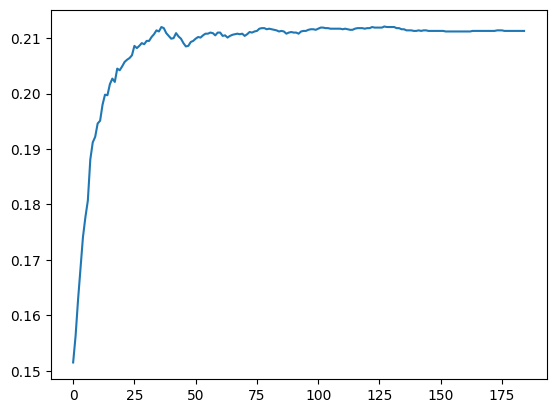

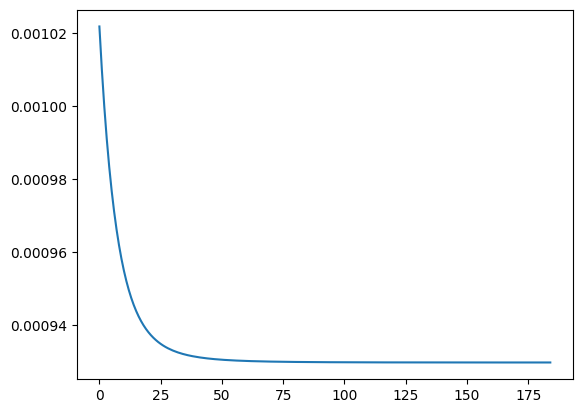

epoch: 1, Validation accuracy = 0.2858
epoch: 21, Validation accuracy = 0.6375
epoch: 41, Validation accuracy = 0.6736
epoch: 61, Validation accuracy = 0.6903
epoch: 81, Validation accuracy = 0.7005
epoch: 101, Validation accuracy = 0.7075
epoch: 121, Validation accuracy = 0.7133
epoch: 141, Validation accuracy = 0.7173
epoch: 161, Validation accuracy = 0.7216
epoch: 181, Validation accuracy = 0.7237
Test accuracy TopConstituents, on all dimensions: 0.7269


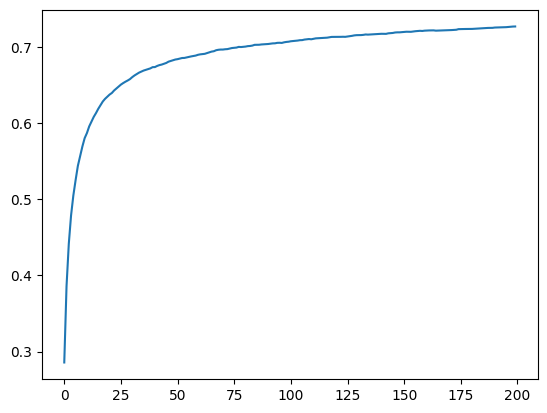

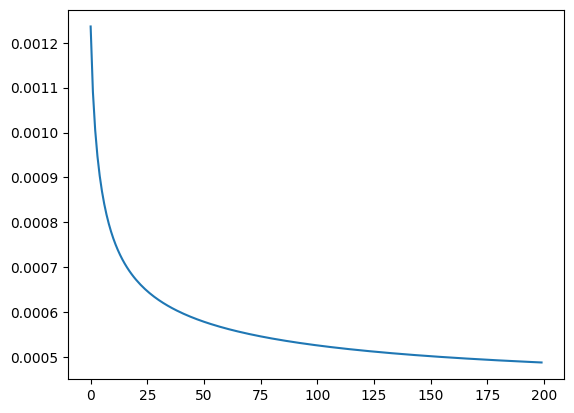

epoch: 1, Validation accuracy = 0.0501
epoch: 21, Validation accuracy = 0.1812
epoch: 41, Validation accuracy = 0.2141
epoch: 61, Validation accuracy = 0.2273
epoch: 81, Validation accuracy = 0.2368
epoch: 101, Validation accuracy = 0.2414
epoch: 121, Validation accuracy = 0.2427
epoch: 141, Validation accuracy = 0.2450
epoch: 161, Validation accuracy = 0.2478
epoch: 181, Validation accuracy = 0.2496
Test accuracy TopConstituents, on outlier dimensions: 0.2478


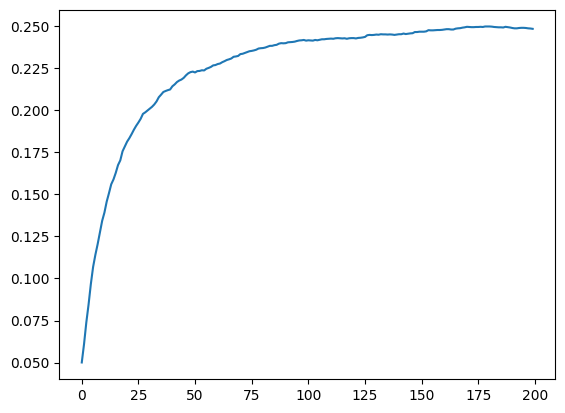

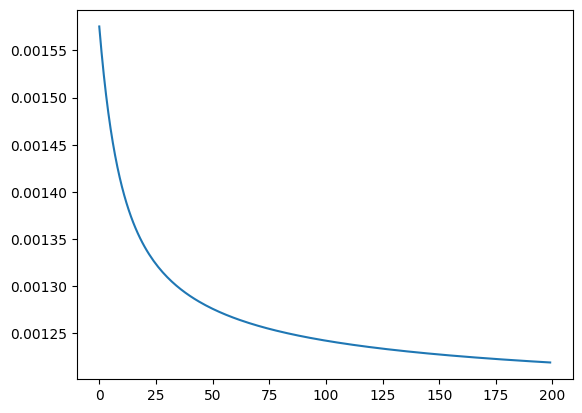

epoch: 1, Validation accuracy = 0.0622
epoch: 21, Validation accuracy = 0.1582
epoch: 41, Validation accuracy = 0.1915
epoch: 61, Validation accuracy = 0.2017
epoch: 81, Validation accuracy = 0.2056
epoch: 101, Validation accuracy = 0.2044
epoch: 121, Validation accuracy = 0.2063
epoch: 141, Validation accuracy = 0.2071
epoch: 161, Validation accuracy = 0.2070
epoch: 181, Validation accuracy = 0.2075
Test accuracy TopConstituents, on random dimensions: 0.2109


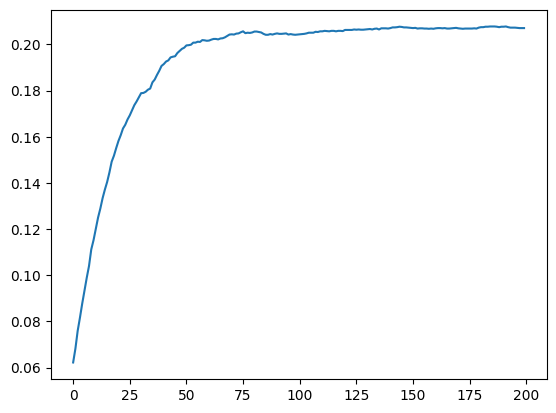

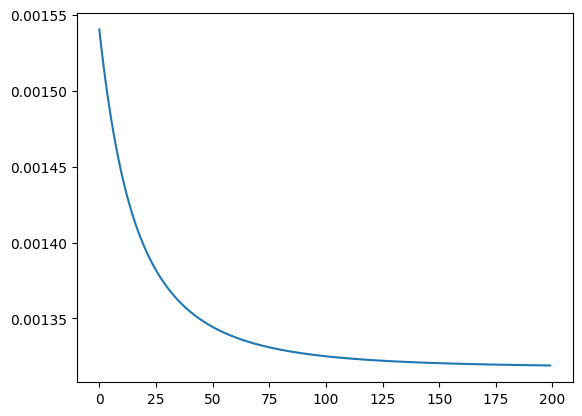

epoch: 1, Validation accuracy = 0.0529
epoch: 21, Validation accuracy = 0.1822
epoch: 41, Validation accuracy = 0.2148
epoch: 61, Validation accuracy = 0.2269
epoch: 81, Validation accuracy = 0.2332
epoch: 101, Validation accuracy = 0.2358
epoch: 121, Validation accuracy = 0.2353
epoch: 141, Validation accuracy = 0.2367
epoch: 161, Validation accuracy = 0.2362
epoch: 181, Validation accuracy = 0.2359
Test accuracy TopConstituents, on random dimensions: 0.2333


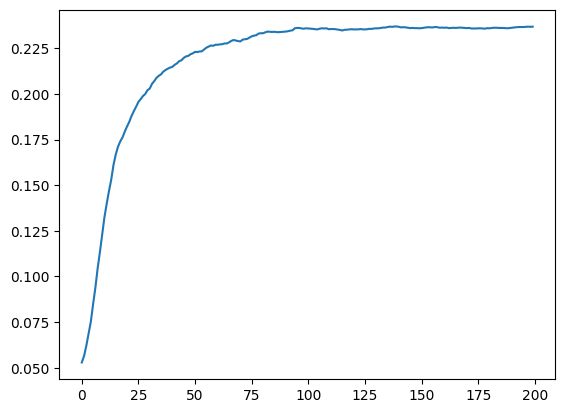

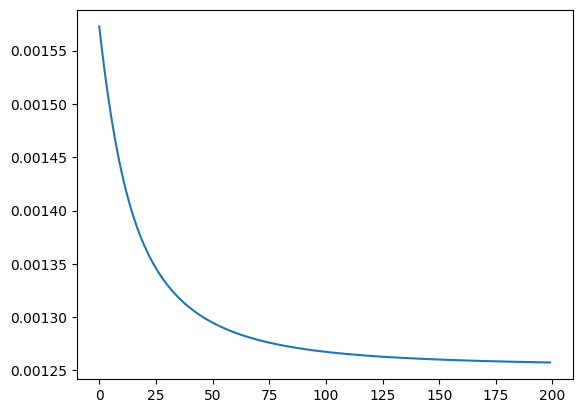

epoch: 1, Validation accuracy = 0.0456
epoch: 21, Validation accuracy = 0.1527
epoch: 41, Validation accuracy = 0.1917
epoch: 61, Validation accuracy = 0.2082
epoch: 81, Validation accuracy = 0.2132
epoch: 101, Validation accuracy = 0.2161
epoch: 121, Validation accuracy = 0.2180
epoch: 141, Validation accuracy = 0.2193
epoch: 161, Validation accuracy = 0.2193
epoch: 181, Validation accuracy = 0.2198
Test accuracy TopConstituents, on random dimensions: 0.2129


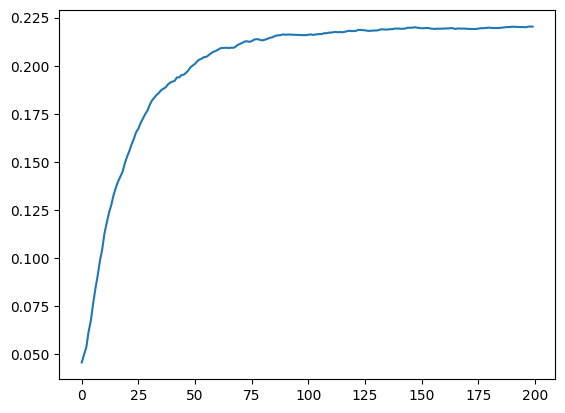

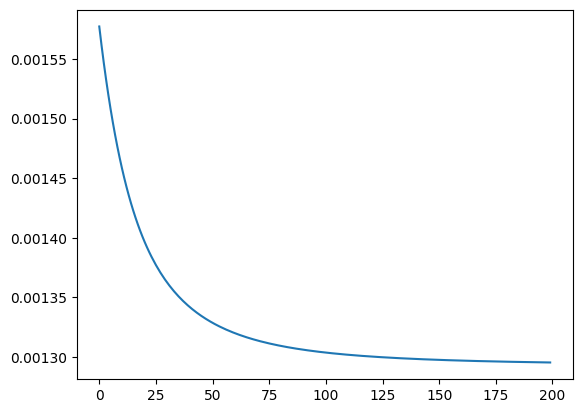

epoch: 1, Validation accuracy = 0.0578
epoch: 21, Validation accuracy = 0.1324
epoch: 41, Validation accuracy = 0.1675
epoch: 61, Validation accuracy = 0.1774
epoch: 81, Validation accuracy = 0.1803
epoch: 101, Validation accuracy = 0.1850
epoch: 121, Validation accuracy = 0.1856
epoch: 141, Validation accuracy = 0.1863
epoch: 161, Validation accuracy = 0.1862
epoch: 181, Validation accuracy = 0.1856
Test accuracy TopConstituents, on random dimensions: 0.1825


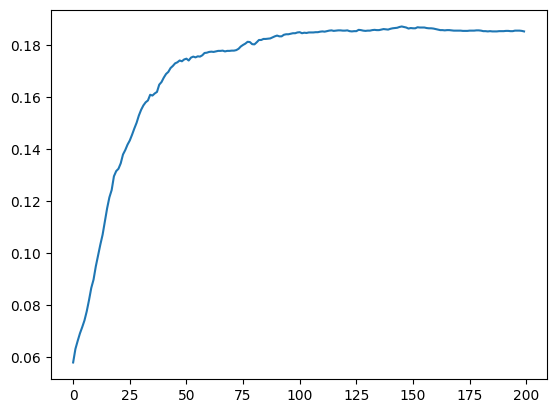

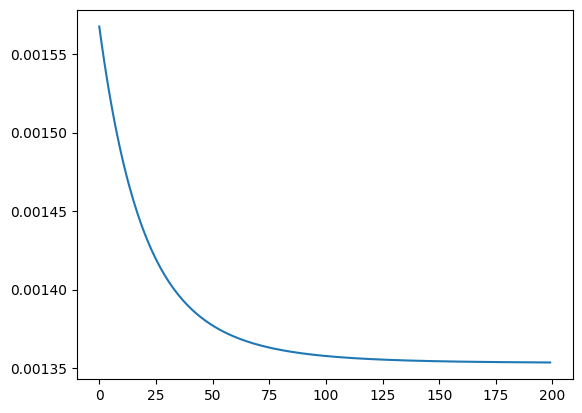

epoch: 1, Validation accuracy = 0.0527
epoch: 21, Validation accuracy = 0.1576
epoch: 41, Validation accuracy = 0.1956
epoch: 61, Validation accuracy = 0.2028
epoch: 81, Validation accuracy = 0.2049
epoch: 101, Validation accuracy = 0.2080
epoch: 121, Validation accuracy = 0.2096
epoch: 141, Validation accuracy = 0.2112
epoch: 161, Validation accuracy = 0.2127
epoch: 181, Validation accuracy = 0.2130
Test accuracy TopConstituents, on random dimensions: 0.2178


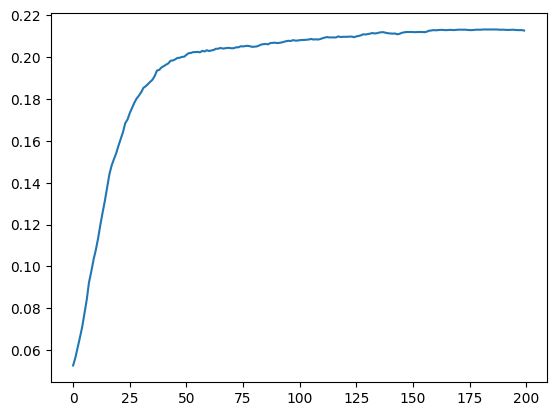

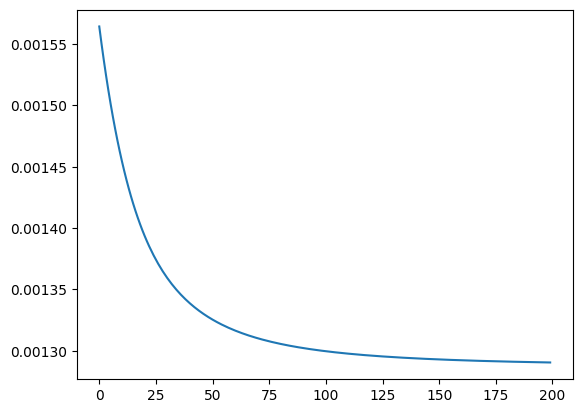

epoch: 1, Validation accuracy = 0.8399
epoch: 21, Validation accuracy = 0.8943
epoch: 41, Validation accuracy = 0.8989
epoch: 61, Validation accuracy = 0.9022
epoch: 81, Validation accuracy = 0.9034
epoch: 101, Validation accuracy = 0.9027
epoch: 121, Validation accuracy = 0.9032
epoch: 141, Validation accuracy = 0.9035
epoch: 161, Validation accuracy = 0.9036
epoch: 181, Validation accuracy = 0.9043
Test accuracy BigramShift, on all dimensions: 0.9024


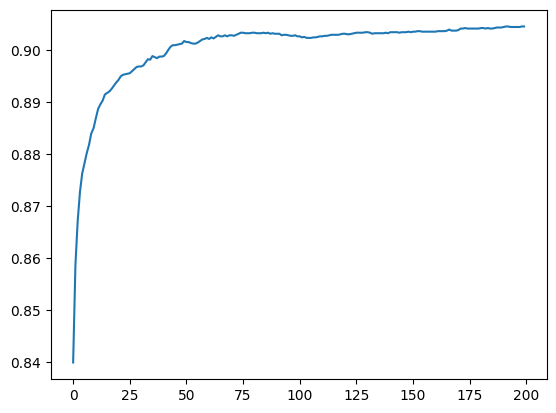

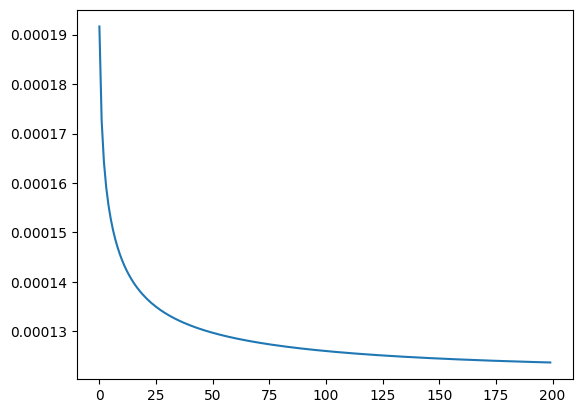

epoch: 1, Validation accuracy = 0.5783
epoch: 21, Validation accuracy = 0.7860
epoch: 41, Validation accuracy = 0.7930
epoch: 61, Validation accuracy = 0.7958
epoch: 81, Validation accuracy = 0.7958
epoch: 101, Validation accuracy = 0.7962
epoch: 121, Validation accuracy = 0.7963
epoch: 141, Validation accuracy = 0.7967
epoch: 161, Validation accuracy = 0.7962
epoch: 181, Validation accuracy = 0.7959
Test accuracy BigramShift, on outlier dimensions: 0.7925


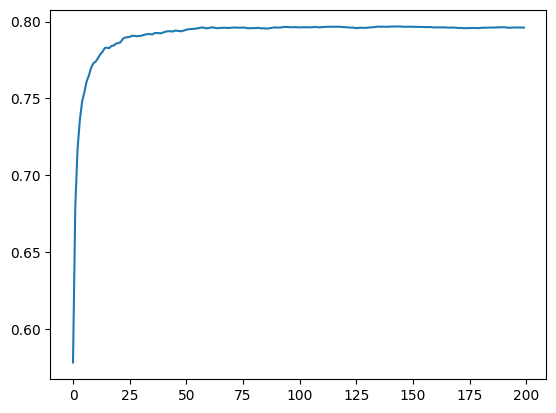

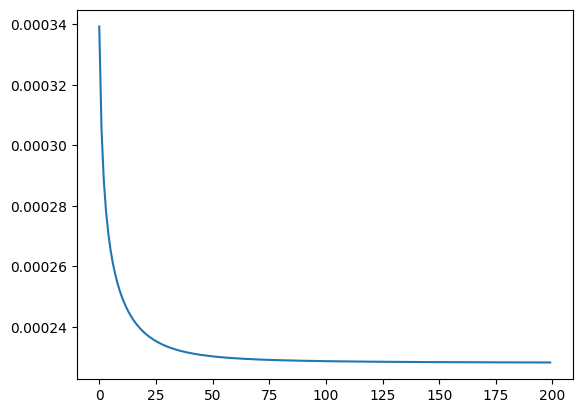

epoch: 1, Validation accuracy = 0.5192
epoch: 21, Validation accuracy = 0.6449
epoch: 41, Validation accuracy = 0.6464
epoch: 61, Validation accuracy = 0.6463
epoch: 81, Validation accuracy = 0.6463
Test accuracy BigramShift, on random dimensions: 0.6374


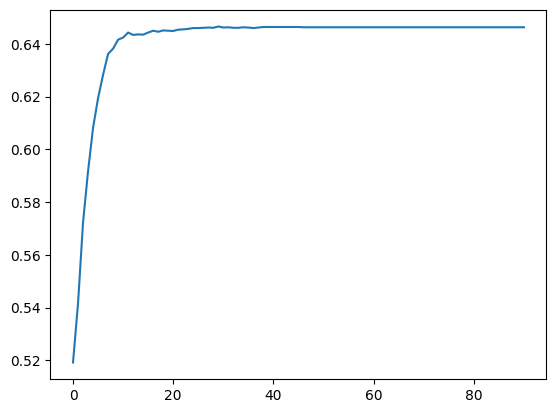

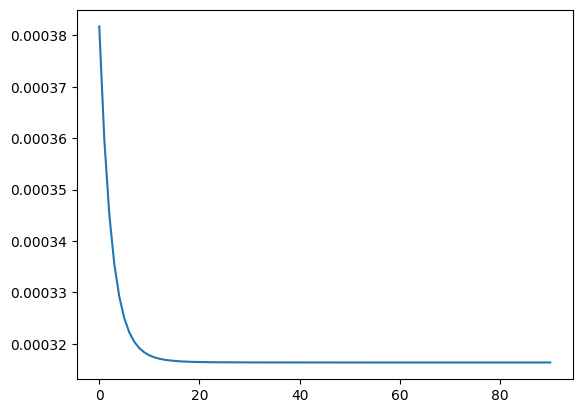

epoch: 1, Validation accuracy = 0.5335
epoch: 21, Validation accuracy = 0.6765
epoch: 41, Validation accuracy = 0.6767
Test accuracy BigramShift, on random dimensions: 0.6675


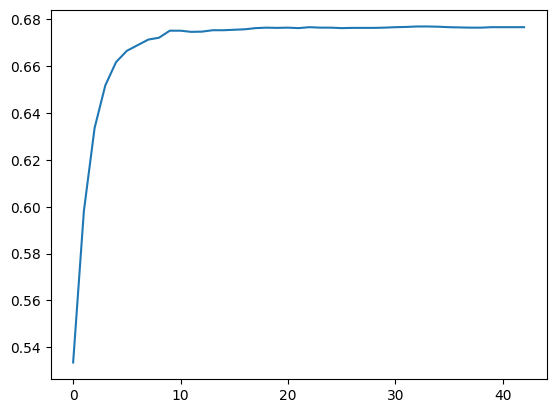

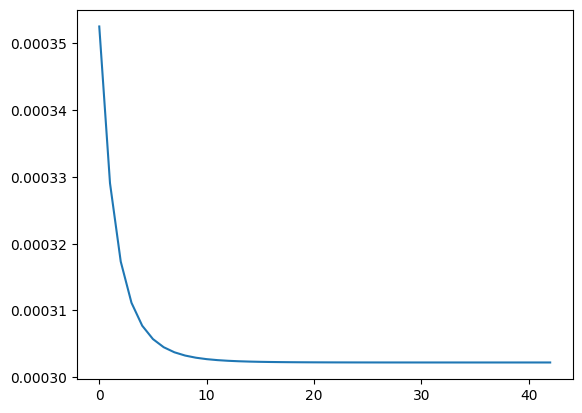

epoch: 1, Validation accuracy = 0.6018
epoch: 21, Validation accuracy = 0.6875
Test accuracy BigramShift, on random dimensions: 0.682


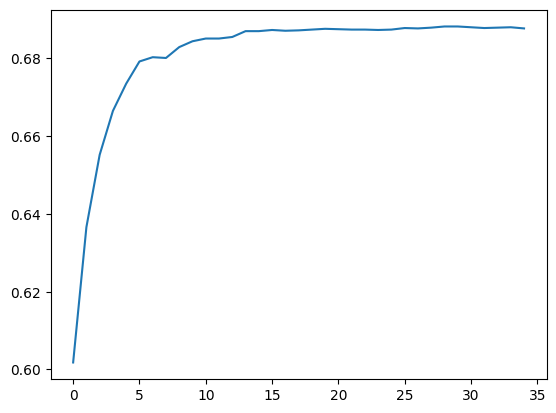

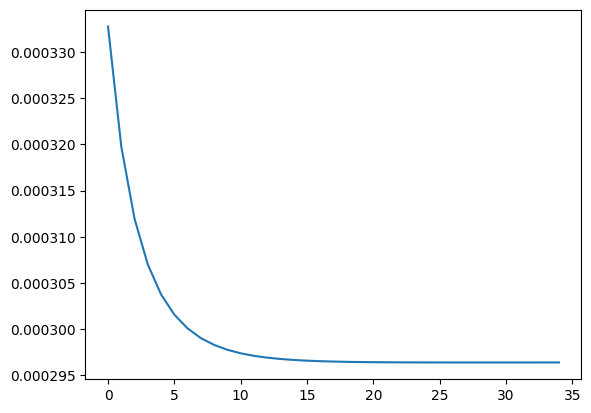

epoch: 1, Validation accuracy = 0.5591
epoch: 21, Validation accuracy = 0.6861
epoch: 41, Validation accuracy = 0.6864
epoch: 61, Validation accuracy = 0.6861
epoch: 81, Validation accuracy = 0.6860
epoch: 101, Validation accuracy = 0.6860
Test accuracy BigramShift, on random dimensions: 0.6853


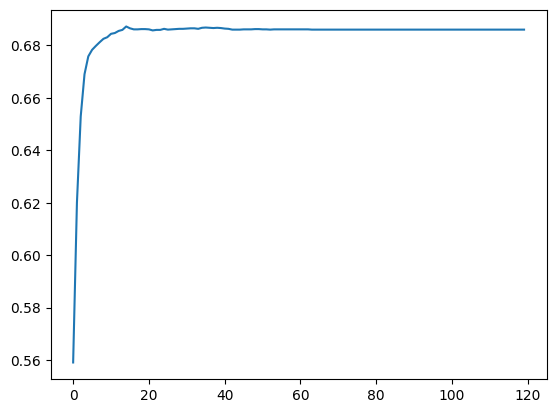

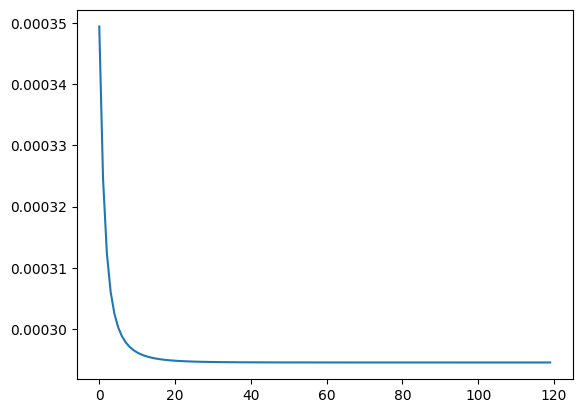

epoch: 1, Validation accuracy = 0.5690
epoch: 21, Validation accuracy = 0.6744
epoch: 41, Validation accuracy = 0.6738
epoch: 61, Validation accuracy = 0.6738
Test accuracy BigramShift, on random dimensions: 0.6714


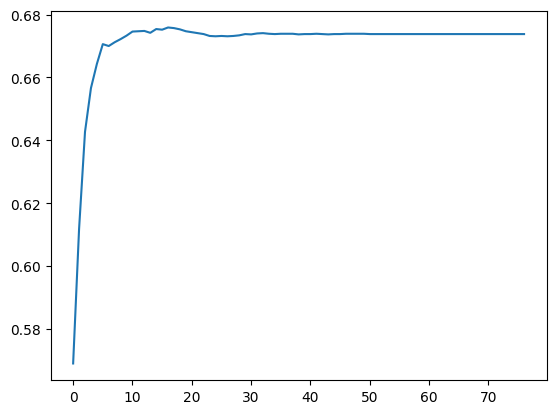

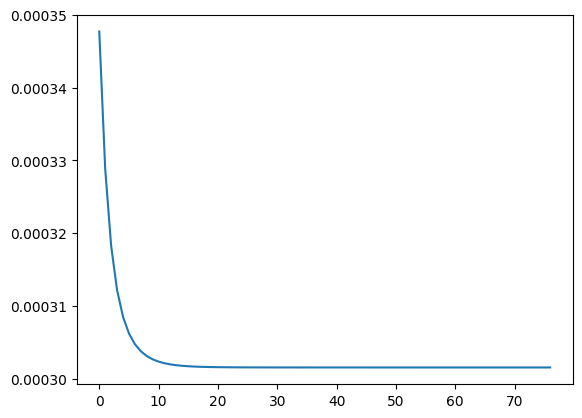

epoch: 1, Validation accuracy = 0.8839
epoch: 21, Validation accuracy = 0.8959
epoch: 41, Validation accuracy = 0.8954
Test accuracy Tense, on all dimensions: 0.8836


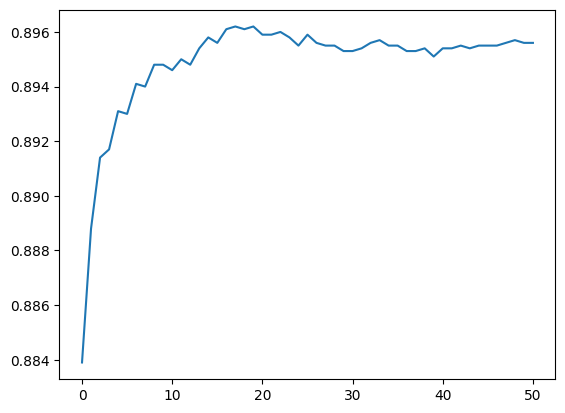

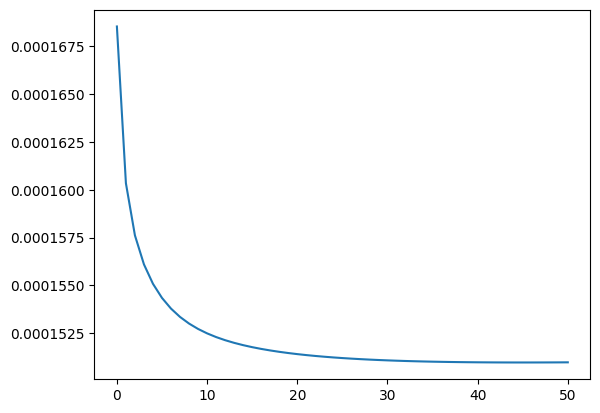

epoch: 1, Validation accuracy = 0.5372
epoch: 21, Validation accuracy = 0.7700
epoch: 41, Validation accuracy = 0.7725
epoch: 61, Validation accuracy = 0.7735
epoch: 81, Validation accuracy = 0.7736
epoch: 101, Validation accuracy = 0.7749
epoch: 121, Validation accuracy = 0.7757
epoch: 141, Validation accuracy = 0.7756
epoch: 161, Validation accuracy = 0.7761
epoch: 181, Validation accuracy = 0.7762
Test accuracy Tense, on outlier dimensions: 0.7436


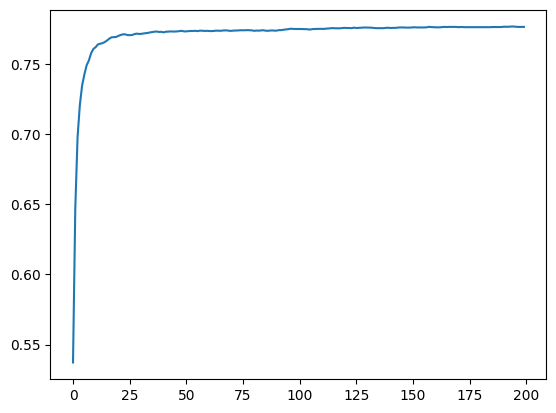

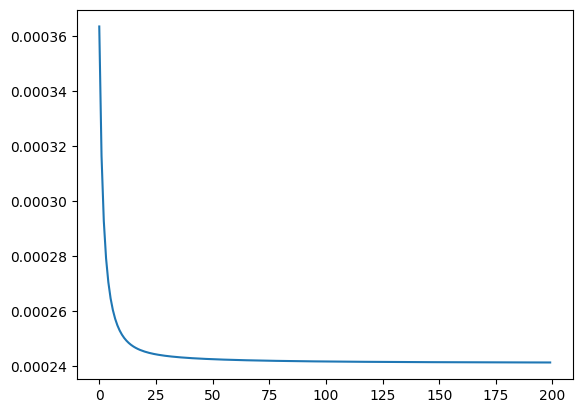

epoch: 1, Validation accuracy = 0.5305
epoch: 21, Validation accuracy = 0.6940
Test accuracy Tense, on random dimensions: 0.6834


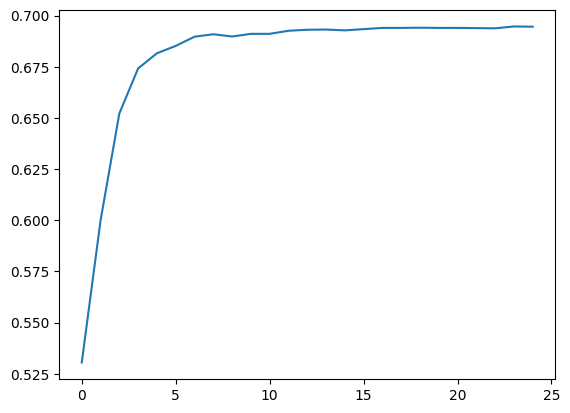

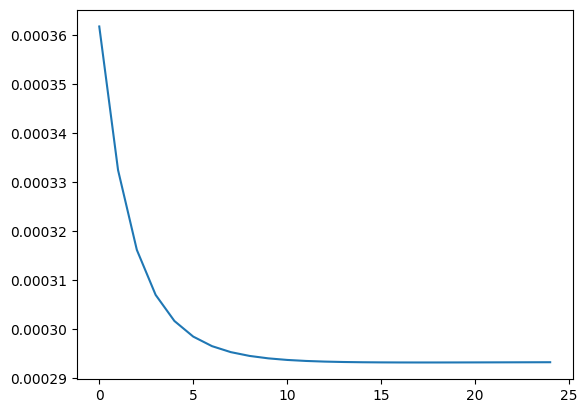

epoch: 1, Validation accuracy = 0.5686
epoch: 21, Validation accuracy = 0.7487
epoch: 41, Validation accuracy = 0.7505
epoch: 61, Validation accuracy = 0.7504
Test accuracy Tense, on random dimensions: 0.7491


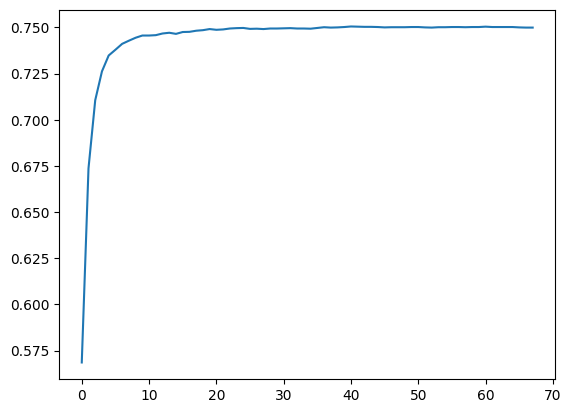

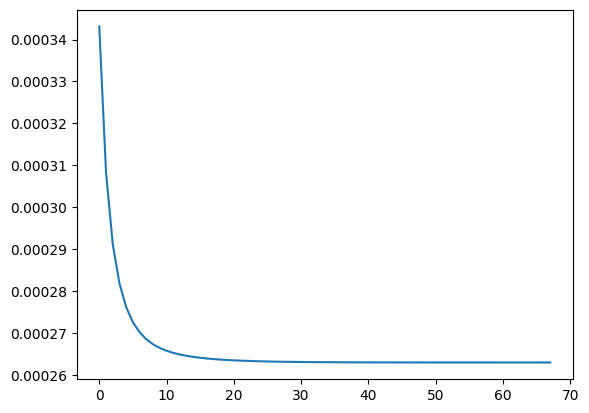

epoch: 1, Validation accuracy = 0.6007
epoch: 21, Validation accuracy = 0.7642
epoch: 41, Validation accuracy = 0.7648
epoch: 61, Validation accuracy = 0.7648
epoch: 81, Validation accuracy = 0.7648
epoch: 101, Validation accuracy = 0.7648
epoch: 121, Validation accuracy = 0.7648
Test accuracy Tense, on random dimensions: 0.7503


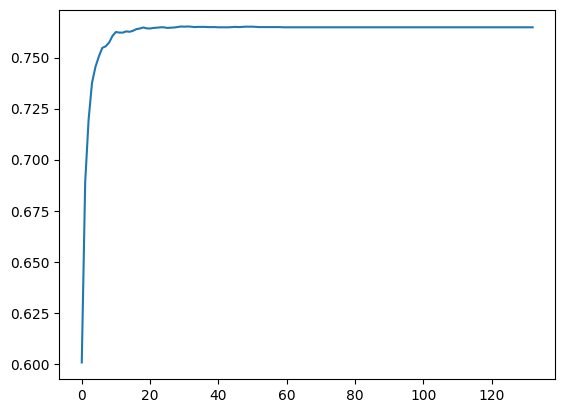

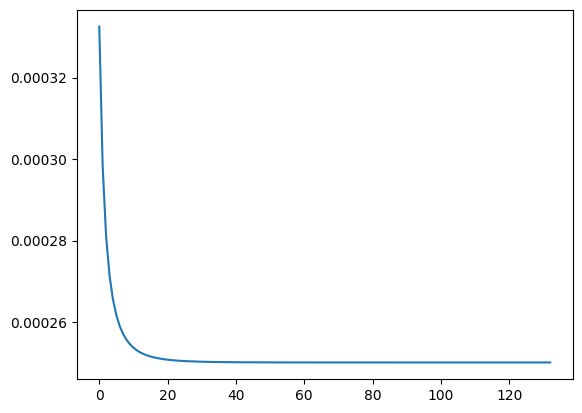

epoch: 1, Validation accuracy = 0.6126
Test accuracy Tense, on random dimensions: 0.6833


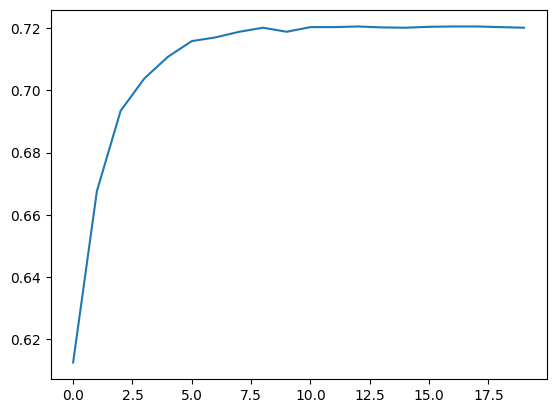

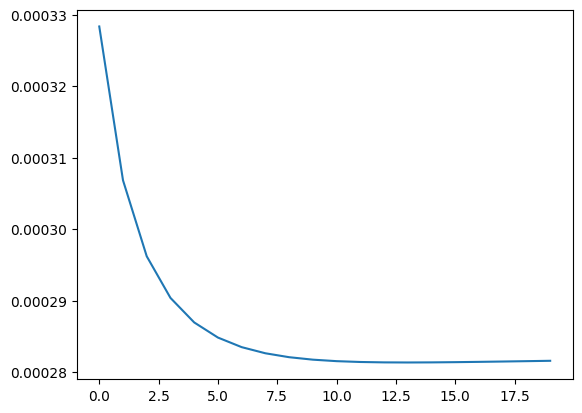

epoch: 1, Validation accuracy = 0.4278
epoch: 21, Validation accuracy = 0.7193
Test accuracy Tense, on random dimensions: 0.7045


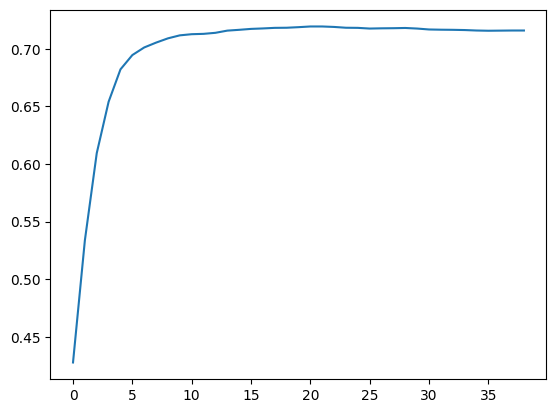

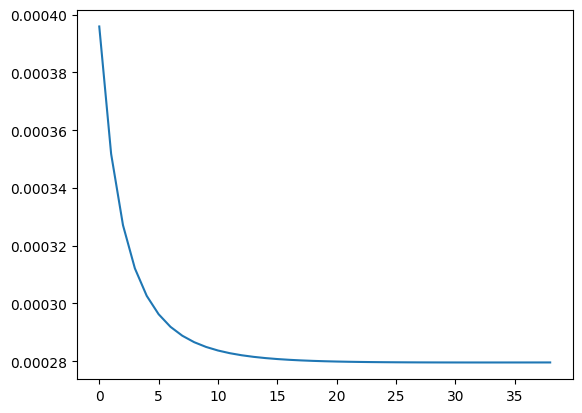

epoch: 1, Validation accuracy = 0.8150
epoch: 21, Validation accuracy = 0.8517
epoch: 41, Validation accuracy = 0.8524
epoch: 61, Validation accuracy = 0.8546
epoch: 81, Validation accuracy = 0.8553
epoch: 101, Validation accuracy = 0.8560
epoch: 121, Validation accuracy = 0.8574
epoch: 141, Validation accuracy = 0.8581
epoch: 161, Validation accuracy = 0.8578
epoch: 181, Validation accuracy = 0.8576
Test accuracy SubjNumber, on all dimensions: 0.8542


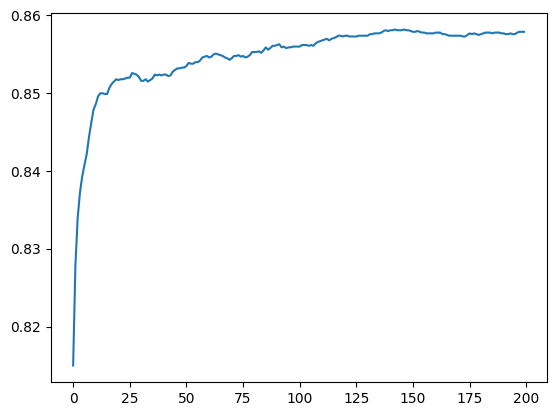

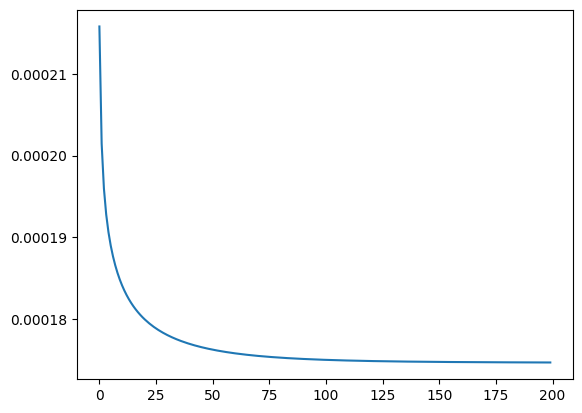

epoch: 1, Validation accuracy = 0.4865
epoch: 21, Validation accuracy = 0.6169
epoch: 41, Validation accuracy = 0.6199
Test accuracy SubjNumber, on outlier dimensions: 0.6328


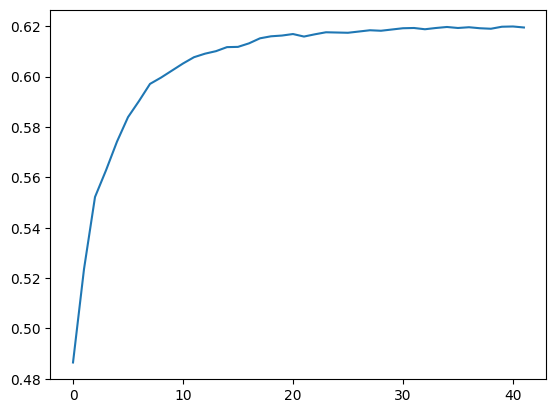

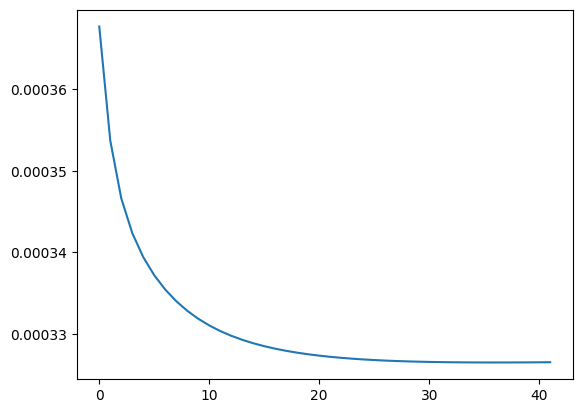

epoch: 1, Validation accuracy = 0.5970
epoch: 21, Validation accuracy = 0.6699
Test accuracy SubjNumber, on random dimensions: 0.6704


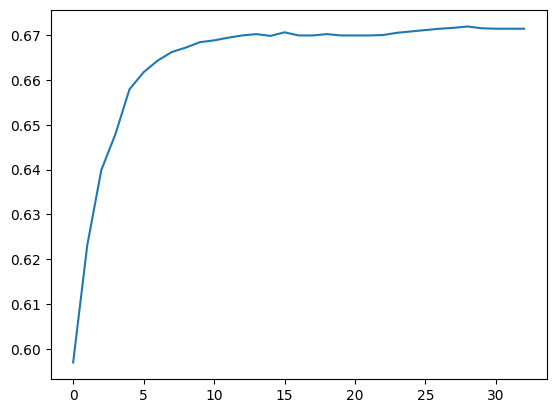

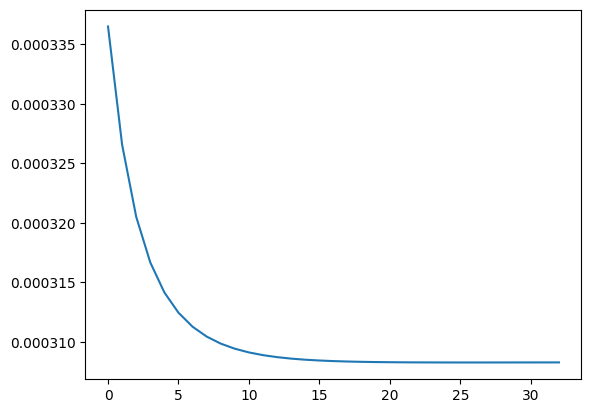

epoch: 1, Validation accuracy = 0.5243
epoch: 21, Validation accuracy = 0.6440
epoch: 41, Validation accuracy = 0.6454
epoch: 61, Validation accuracy = 0.6452
epoch: 81, Validation accuracy = 0.6453
Test accuracy SubjNumber, on random dimensions: 0.6389


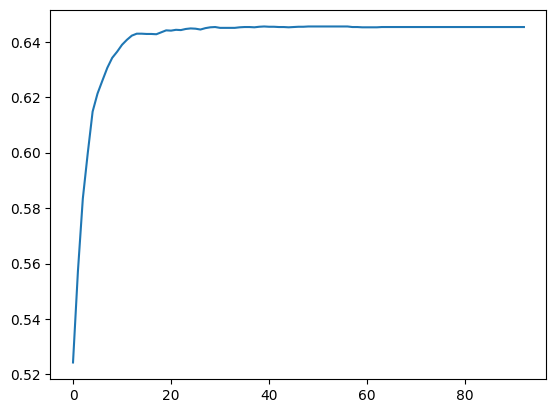

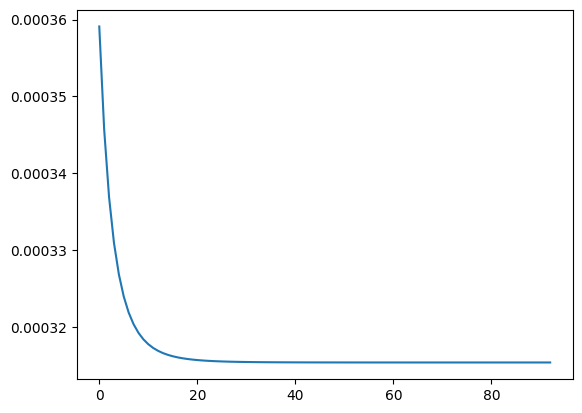

epoch: 1, Validation accuracy = 0.5290
epoch: 21, Validation accuracy = 0.6299
Test accuracy SubjNumber, on random dimensions: 0.6094


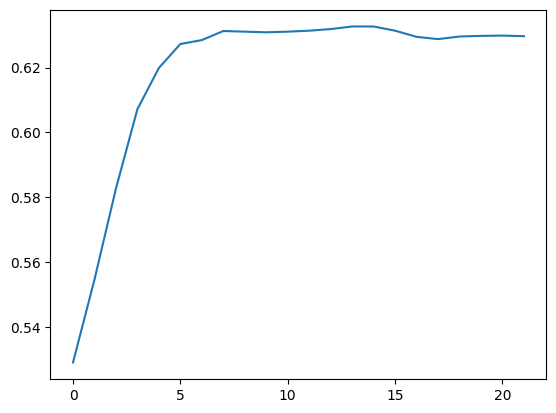

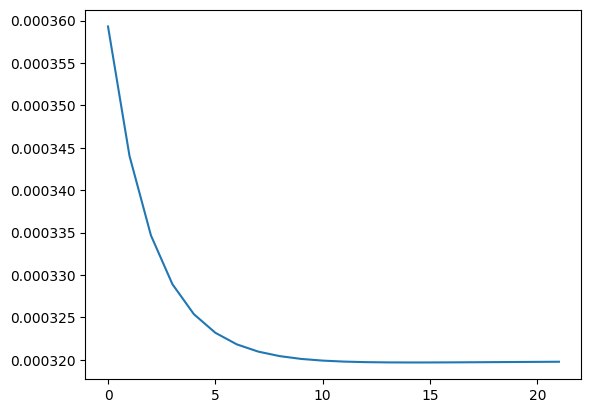

epoch: 1, Validation accuracy = 0.4407
epoch: 21, Validation accuracy = 0.6264
epoch: 41, Validation accuracy = 0.6285
Test accuracy SubjNumber, on random dimensions: 0.6134


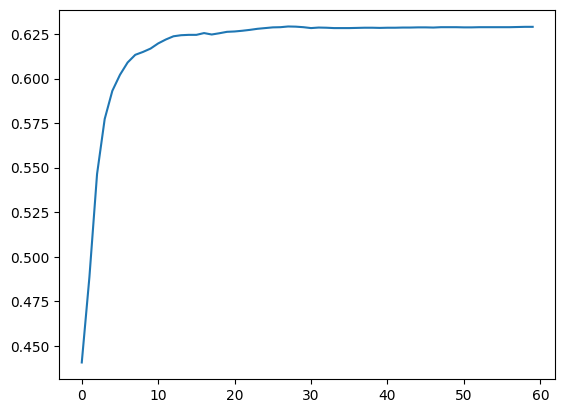

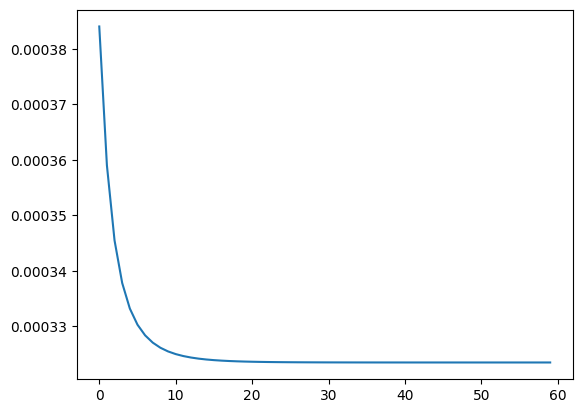

epoch: 1, Validation accuracy = 0.5983
epoch: 21, Validation accuracy = 0.6699
Test accuracy SubjNumber, on random dimensions: 0.6446


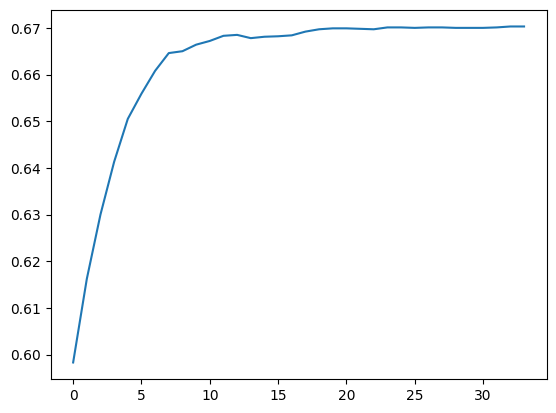

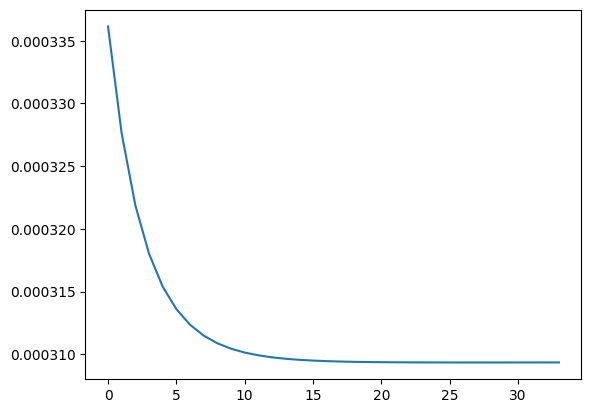

epoch: 1, Validation accuracy = 0.7677
epoch: 21, Validation accuracy = 0.8199
epoch: 41, Validation accuracy = 0.8235
epoch: 61, Validation accuracy = 0.8233
epoch: 81, Validation accuracy = 0.8229
Test accuracy ObjNumber, on all dimensions: 0.8314


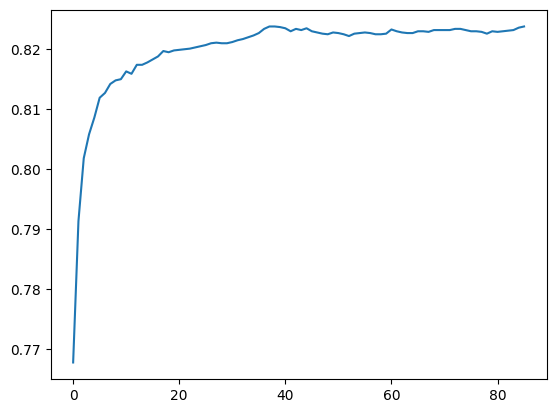

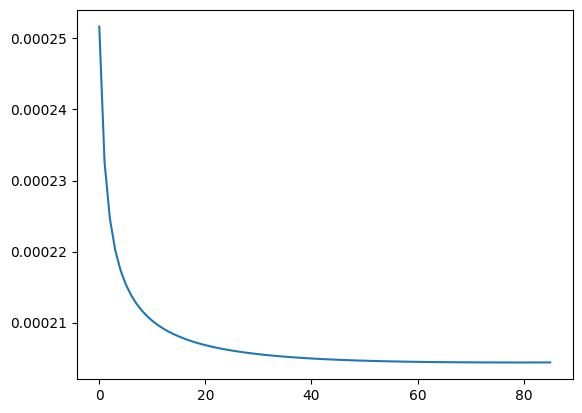

epoch: 1, Validation accuracy = 0.5403
epoch: 21, Validation accuracy = 0.6216
epoch: 41, Validation accuracy = 0.6222
epoch: 61, Validation accuracy = 0.6231
Test accuracy ObjNumber, on outlier dimensions: 0.6299


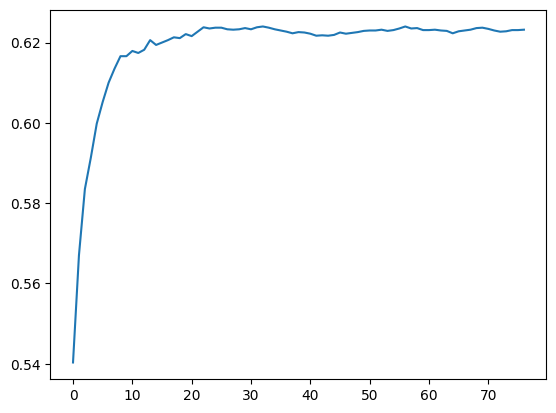

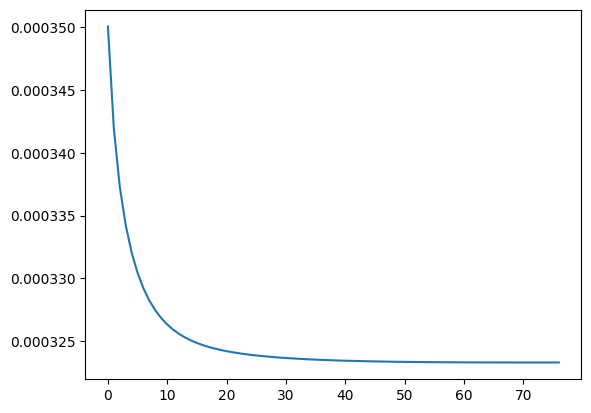

epoch: 1, Validation accuracy = 0.5333
epoch: 21, Validation accuracy = 0.6041
Test accuracy ObjNumber, on random dimensions: 0.6193


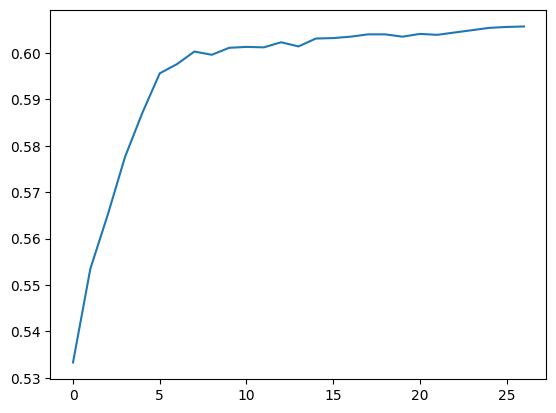

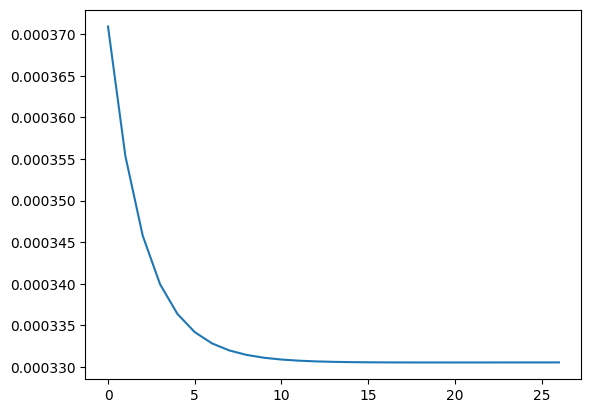

epoch: 1, Validation accuracy = 0.5090
epoch: 21, Validation accuracy = 0.5941
Test accuracy ObjNumber, on random dimensions: 0.5862


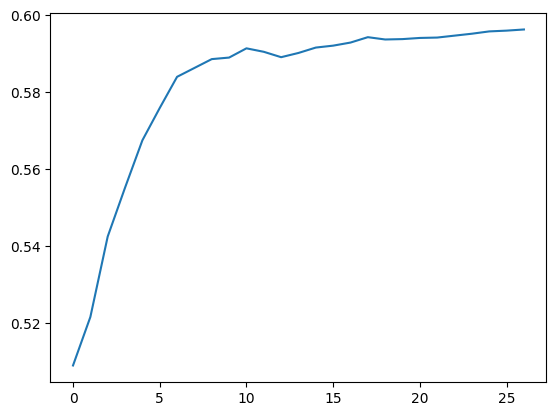

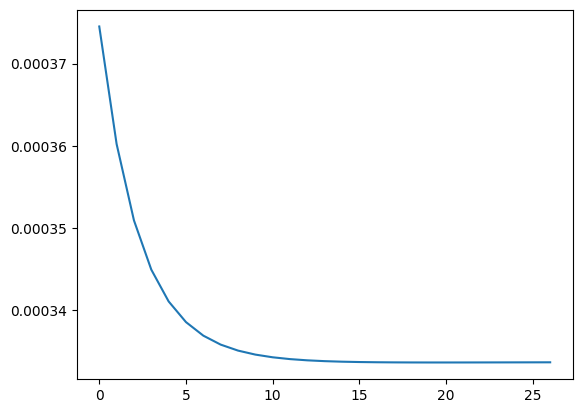

epoch: 1, Validation accuracy = 0.5044
epoch: 21, Validation accuracy = 0.5988
Test accuracy ObjNumber, on random dimensions: 0.609


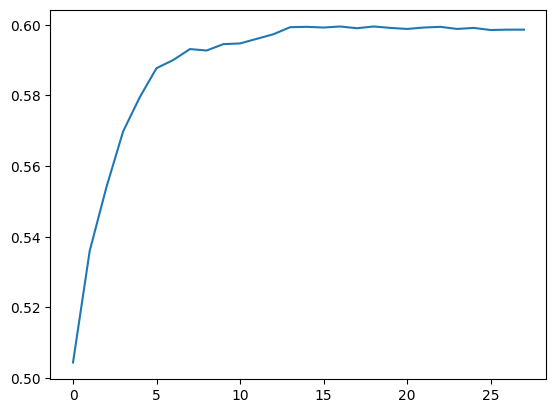

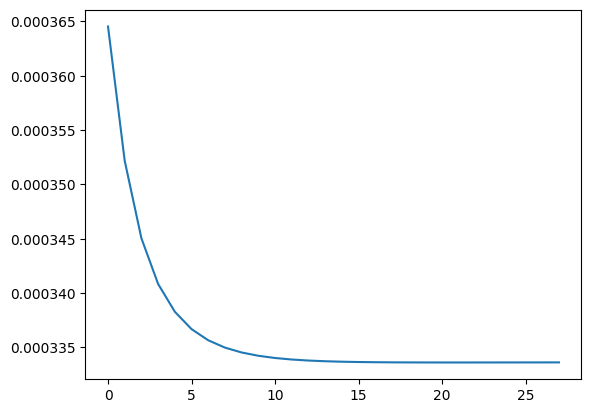

epoch: 1, Validation accuracy = 0.5722
Test accuracy ObjNumber, on random dimensions: 0.6382


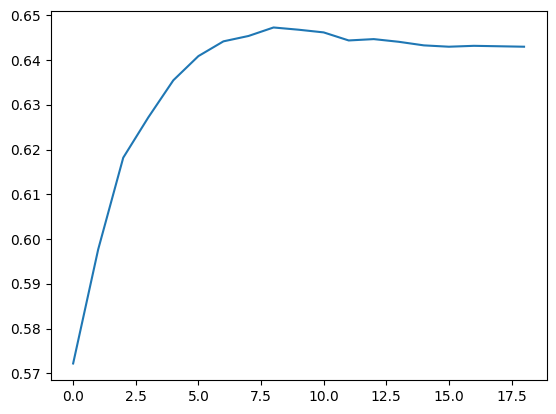

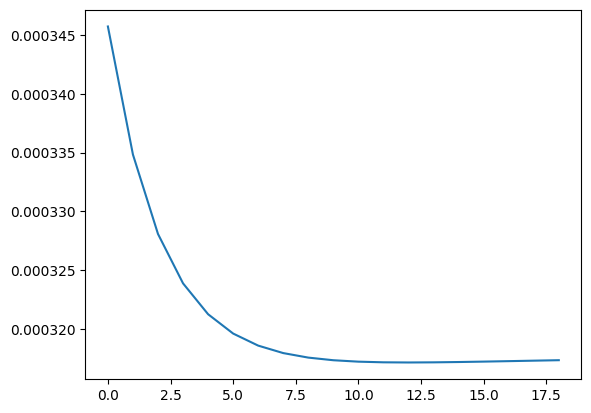

epoch: 1, Validation accuracy = 0.5066
epoch: 21, Validation accuracy = 0.6171
Test accuracy ObjNumber, on random dimensions: 0.6233


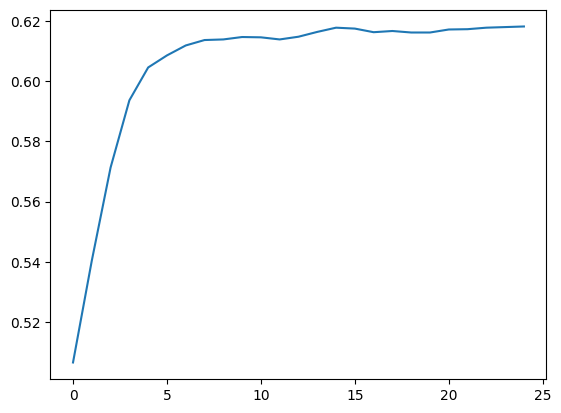

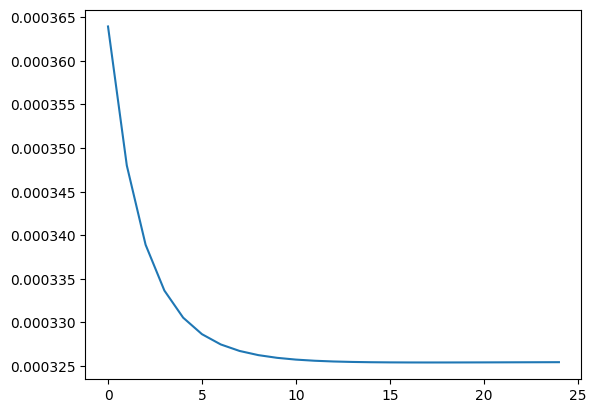

epoch: 1, Validation accuracy = 0.6153
epoch: 21, Validation accuracy = 0.6894
epoch: 41, Validation accuracy = 0.6881
epoch: 61, Validation accuracy = 0.6891
epoch: 81, Validation accuracy = 0.6904
epoch: 101, Validation accuracy = 0.6919
epoch: 121, Validation accuracy = 0.6925
epoch: 141, Validation accuracy = 0.6930
epoch: 161, Validation accuracy = 0.6921
epoch: 181, Validation accuracy = 0.6918
Test accuracy OddManOut, on all dimensions: 0.6859


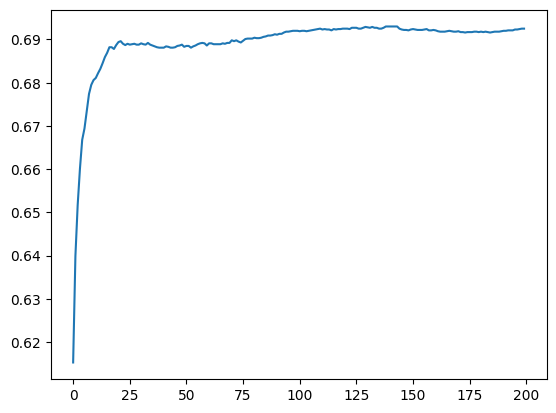

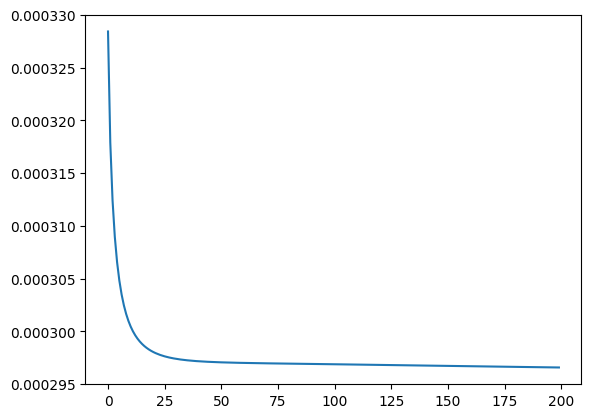

epoch: 1, Validation accuracy = 0.4950
epoch: 21, Validation accuracy = 0.6324
epoch: 41, Validation accuracy = 0.6357
epoch: 61, Validation accuracy = 0.6380
epoch: 81, Validation accuracy = 0.6373
epoch: 101, Validation accuracy = 0.6383
epoch: 121, Validation accuracy = 0.6387
epoch: 141, Validation accuracy = 0.6398
epoch: 161, Validation accuracy = 0.6400
epoch: 181, Validation accuracy = 0.6404
Test accuracy OddManOut, on outlier dimensions: 0.6276


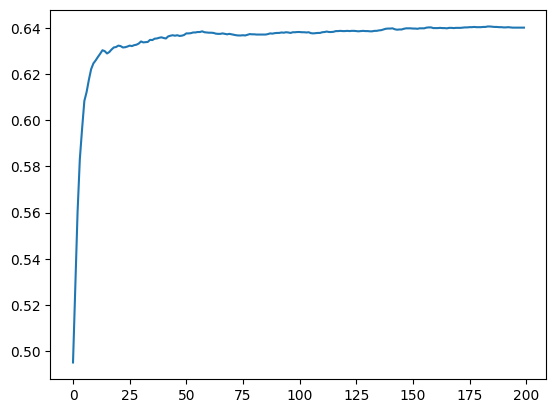

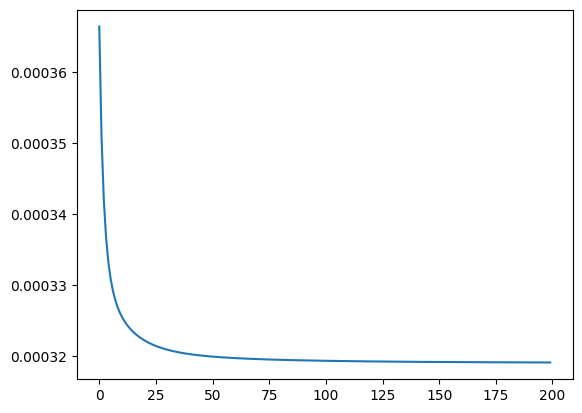

epoch: 1, Validation accuracy = 0.5166
epoch: 21, Validation accuracy = 0.5590
Test accuracy OddManOut, on random dimensions: 0.5628


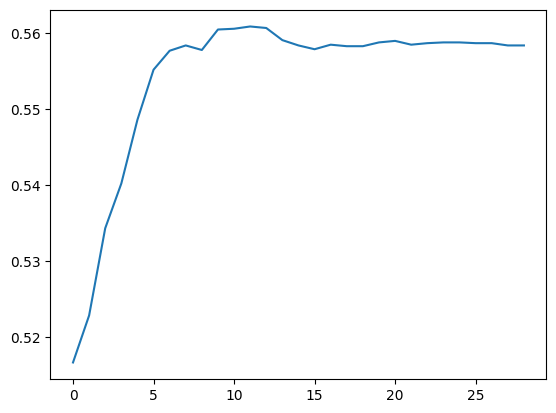

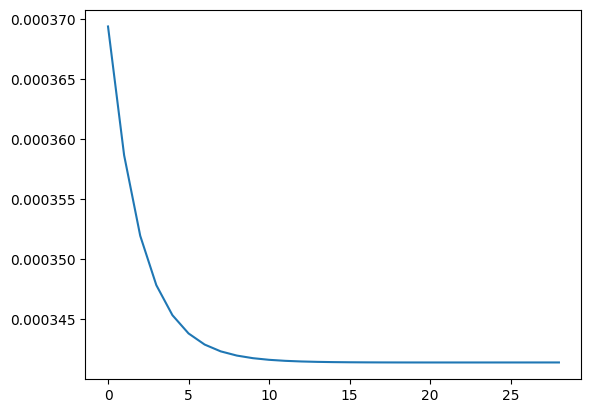

epoch: 1, Validation accuracy = 0.5064
epoch: 21, Validation accuracy = 0.5624
epoch: 41, Validation accuracy = 0.5627
epoch: 61, Validation accuracy = 0.5628
Test accuracy OddManOut, on random dimensions: 0.5515


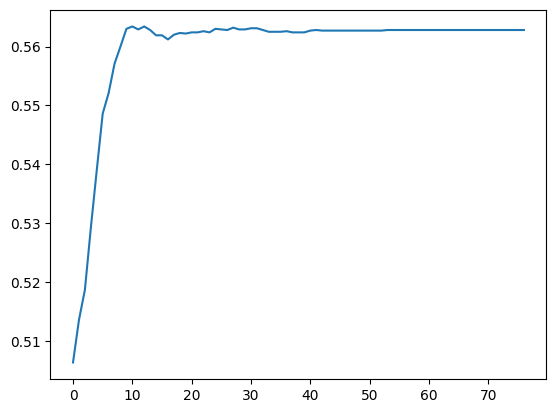

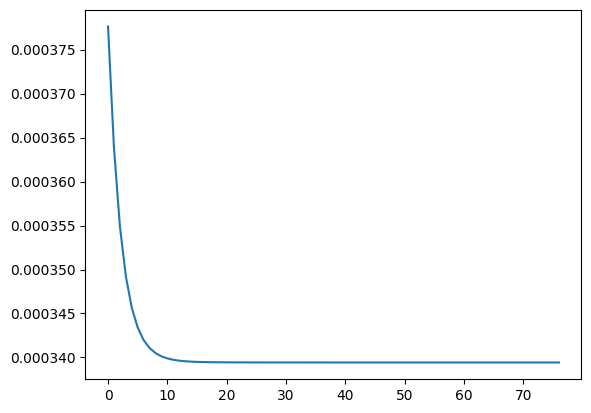

epoch: 1, Validation accuracy = 0.5028
epoch: 21, Validation accuracy = 0.5646
epoch: 41, Validation accuracy = 0.5655
epoch: 61, Validation accuracy = 0.5654
Test accuracy OddManOut, on random dimensions: 0.5588


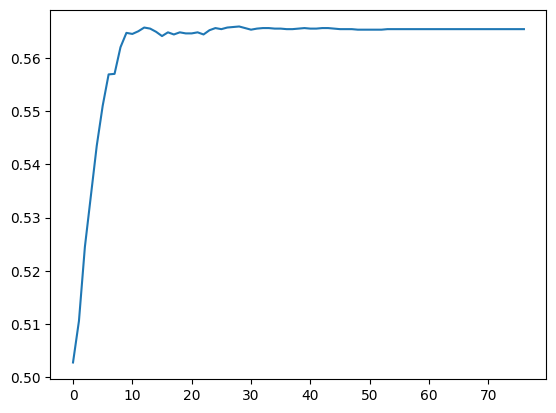

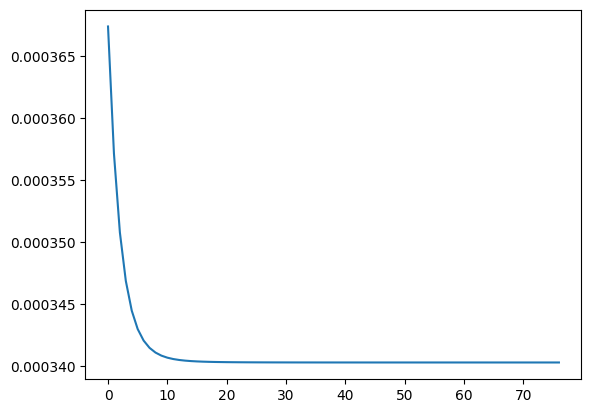

epoch: 1, Validation accuracy = 0.4636
epoch: 21, Validation accuracy = 0.5575
epoch: 41, Validation accuracy = 0.5575
epoch: 61, Validation accuracy = 0.5575
epoch: 81, Validation accuracy = 0.5575
Test accuracy OddManOut, on random dimensions: 0.5525


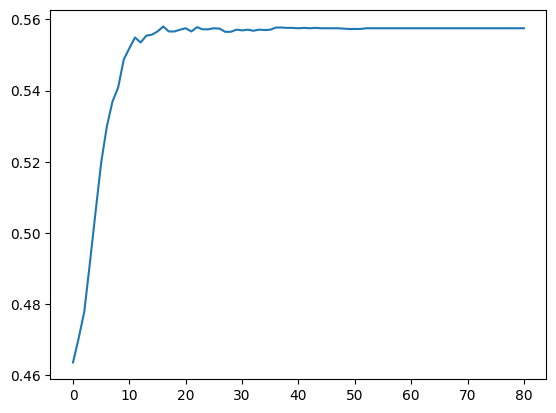

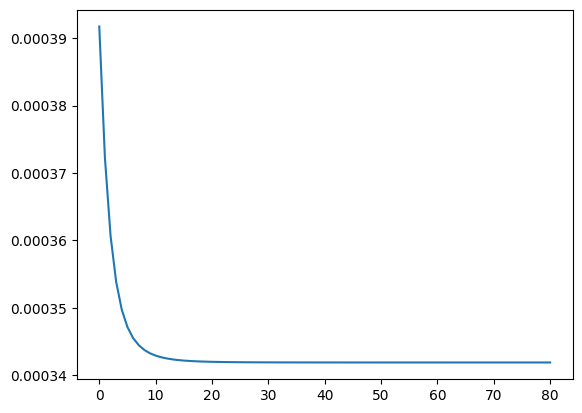

epoch: 1, Validation accuracy = 0.5147
epoch: 21, Validation accuracy = 0.5873
Test accuracy OddManOut, on random dimensions: 0.5786


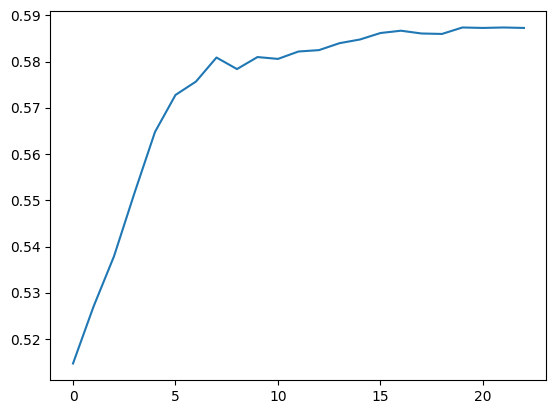

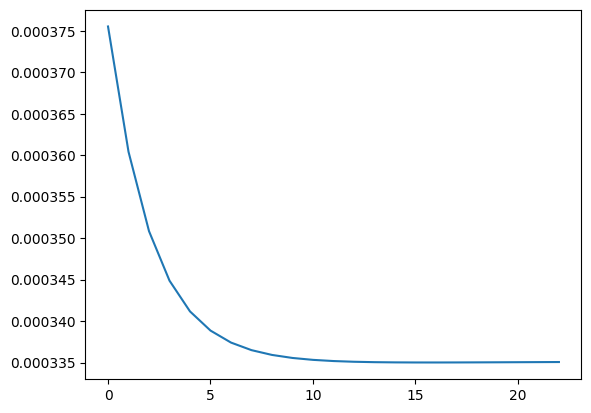

epoch: 1, Validation accuracy = 0.6100
epoch: 21, Validation accuracy = 0.7028
epoch: 41, Validation accuracy = 0.7072
epoch: 61, Validation accuracy = 0.7082
epoch: 81, Validation accuracy = 0.7093
epoch: 101, Validation accuracy = 0.7097
epoch: 121, Validation accuracy = 0.7096
epoch: 141, Validation accuracy = 0.7097
epoch: 161, Validation accuracy = 0.7106
epoch: 181, Validation accuracy = 0.7097
Test accuracy CoordinationInversion, on all dimensions: 0.7140571885622875


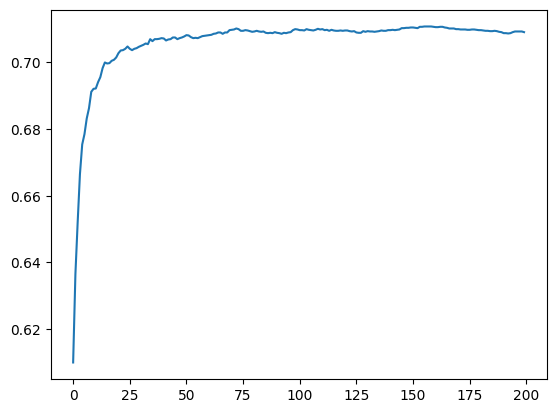

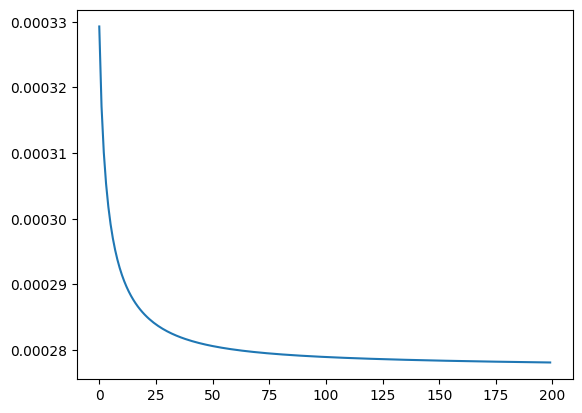

epoch: 1, Validation accuracy = 0.5111
epoch: 21, Validation accuracy = 0.5869
epoch: 41, Validation accuracy = 0.5881
epoch: 61, Validation accuracy = 0.5918
epoch: 81, Validation accuracy = 0.5903
epoch: 101, Validation accuracy = 0.5902
Test accuracy CoordinationInversion, on outlier dimensions: 0.595380923815237


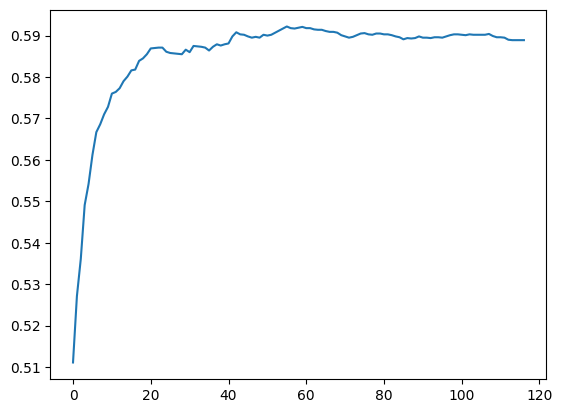

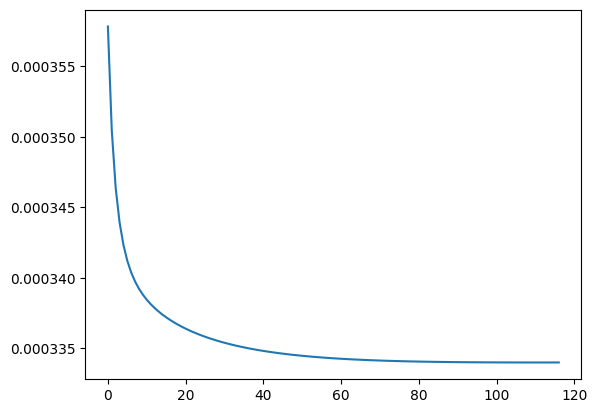

epoch: 1, Validation accuracy = 0.5090
epoch: 21, Validation accuracy = 0.5525
epoch: 41, Validation accuracy = 0.5513
epoch: 61, Validation accuracy = 0.5515
epoch: 81, Validation accuracy = 0.5517
Test accuracy CoordinationInversion, on random dimensions: 0.5459908018396321


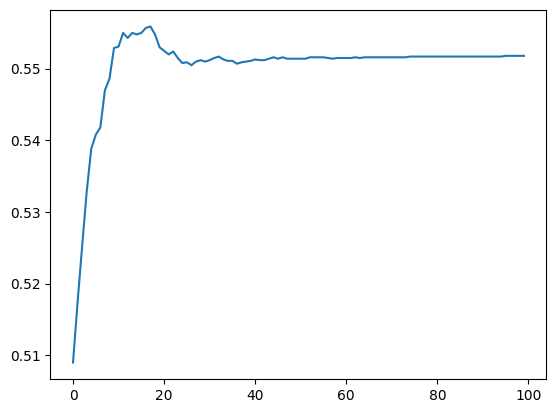

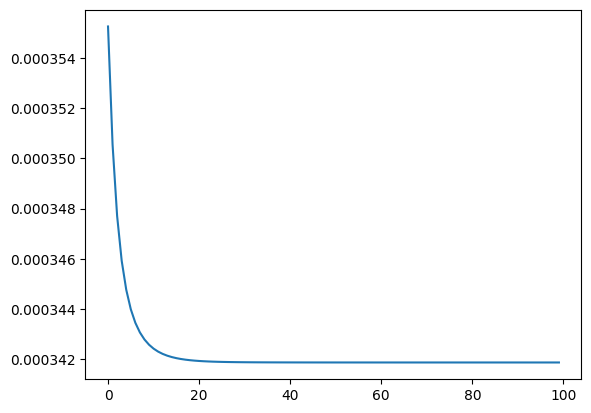

epoch: 1, Validation accuracy = 0.5067
epoch: 21, Validation accuracy = 0.5516
epoch: 41, Validation accuracy = 0.5507
epoch: 61, Validation accuracy = 0.5513
Test accuracy CoordinationInversion, on random dimensions: 0.5493901219756049


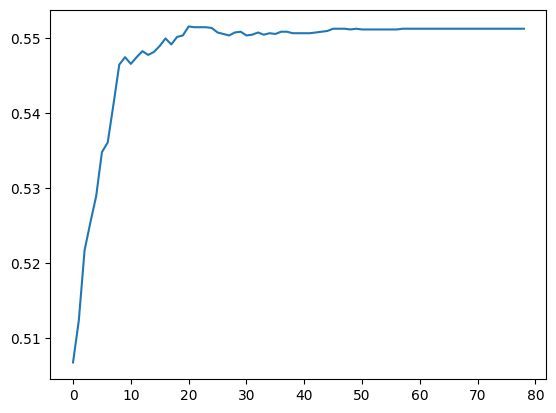

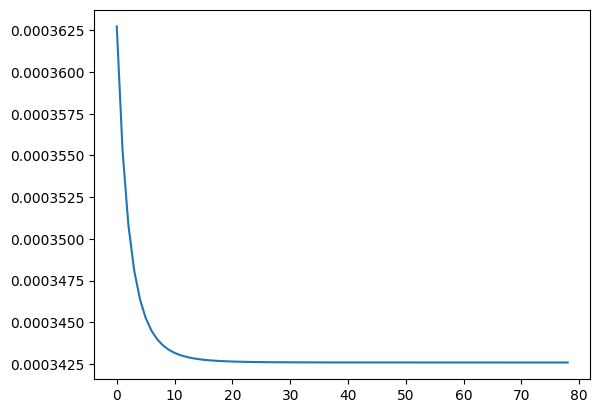

epoch: 1, Validation accuracy = 0.4937
epoch: 21, Validation accuracy = 0.5489
epoch: 41, Validation accuracy = 0.5476
epoch: 61, Validation accuracy = 0.5477
Test accuracy CoordinationInversion, on random dimensions: 0.5364927014597081


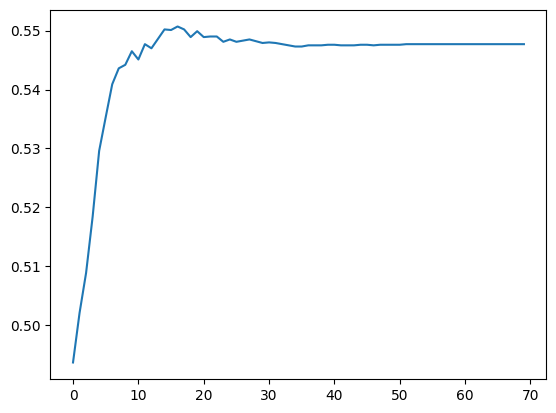

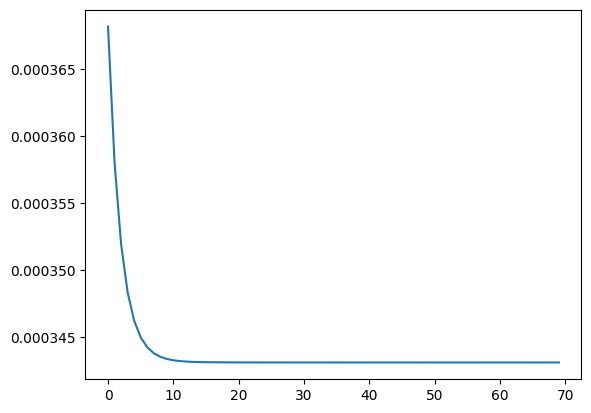

epoch: 1, Validation accuracy = 0.5051
epoch: 21, Validation accuracy = 0.5383
Test accuracy CoordinationInversion, on random dimensions: 0.5428914217156569


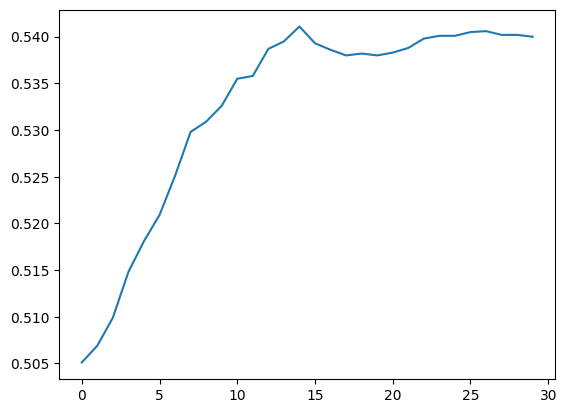

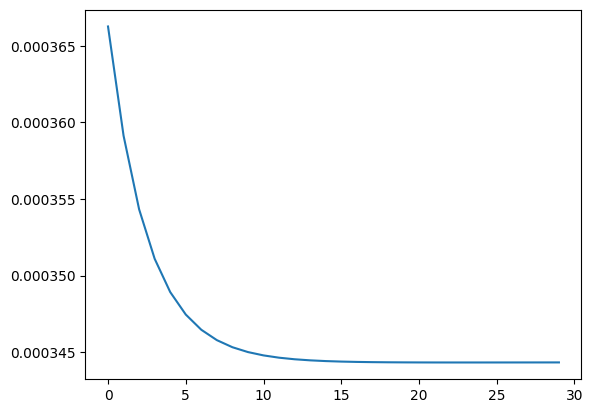

epoch: 1, Validation accuracy = 0.5082
epoch: 21, Validation accuracy = 0.5467
Test accuracy CoordinationInversion, on random dimensions: 0.5489902019596081


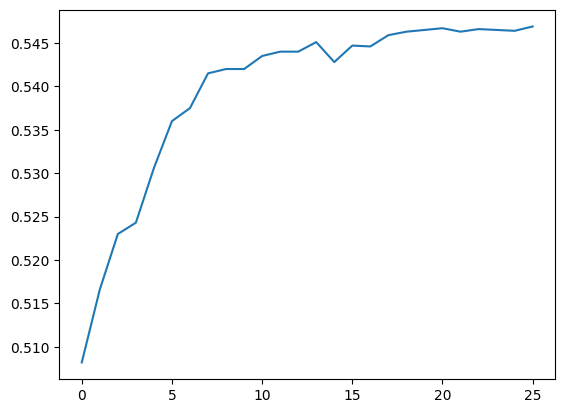

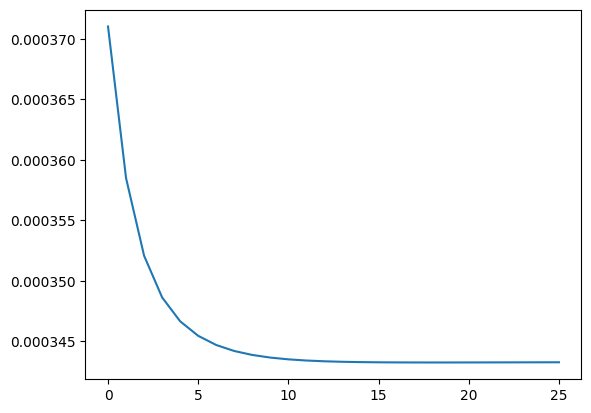

epoch: 1, Validation accuracy = 0.0018
epoch: 21, Validation accuracy = 0.0717
epoch: 41, Validation accuracy = 0.1667
epoch: 61, Validation accuracy = 0.2420
epoch: 81, Validation accuracy = 0.2977
epoch: 101, Validation accuracy = 0.3383
epoch: 121, Validation accuracy = 0.3719
epoch: 141, Validation accuracy = 0.3974
epoch: 161, Validation accuracy = 0.4168
epoch: 181, Validation accuracy = 0.4340
Test accuracy WordContent, on all dimensions: 0.4506


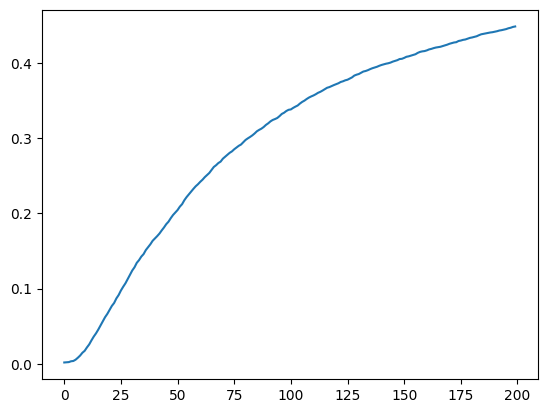

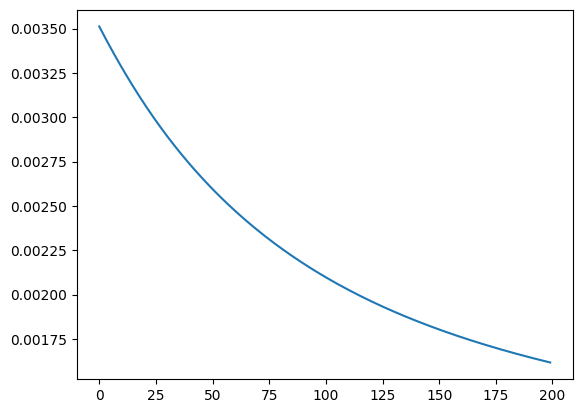

epoch: 1, Validation accuracy = 0.0005
epoch: 21, Validation accuracy = 0.0006
epoch: 41, Validation accuracy = 0.0012
epoch: 61, Validation accuracy = 0.0017
epoch: 81, Validation accuracy = 0.0020
epoch: 101, Validation accuracy = 0.0027
epoch: 121, Validation accuracy = 0.0029
epoch: 141, Validation accuracy = 0.0037
epoch: 161, Validation accuracy = 0.0042
epoch: 181, Validation accuracy = 0.0043
Test accuracy WordContent, on outlier dimensions: 0.0048


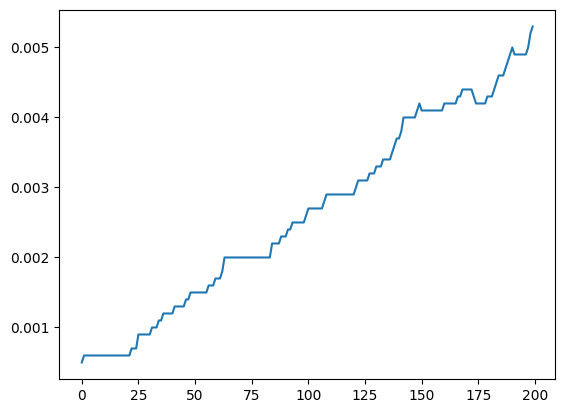

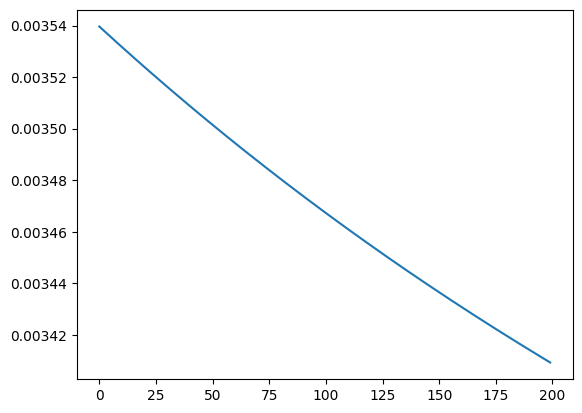

epoch: 1, Validation accuracy = 0.0009
epoch: 21, Validation accuracy = 0.0010
epoch: 41, Validation accuracy = 0.0010
epoch: 61, Validation accuracy = 0.0010
epoch: 81, Validation accuracy = 0.0014
epoch: 101, Validation accuracy = 0.0016
epoch: 121, Validation accuracy = 0.0019
epoch: 141, Validation accuracy = 0.0025
epoch: 161, Validation accuracy = 0.0027
epoch: 181, Validation accuracy = 0.0032
Test accuracy WordContent, on random dimensions: 0.0057


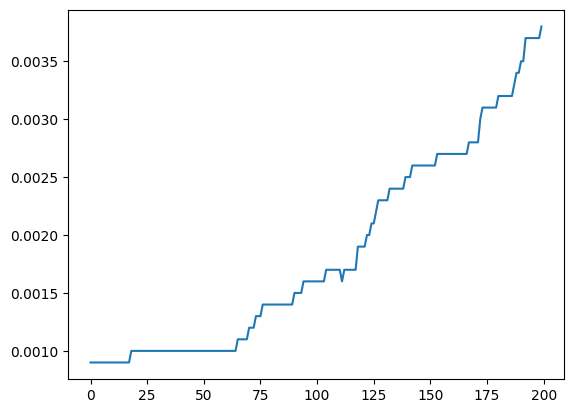

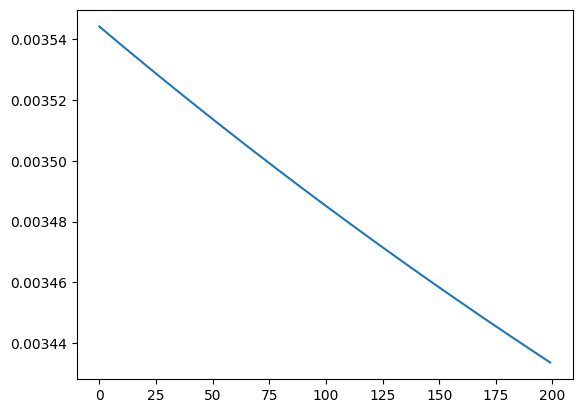

epoch: 1, Validation accuracy = 0.0008
epoch: 21, Validation accuracy = 0.0007
epoch: 41, Validation accuracy = 0.0009
epoch: 61, Validation accuracy = 0.0009
epoch: 81, Validation accuracy = 0.0012
epoch: 101, Validation accuracy = 0.0020
epoch: 121, Validation accuracy = 0.0022
epoch: 141, Validation accuracy = 0.0027
epoch: 161, Validation accuracy = 0.0029
epoch: 181, Validation accuracy = 0.0036
Test accuracy WordContent, on random dimensions: 0.0054


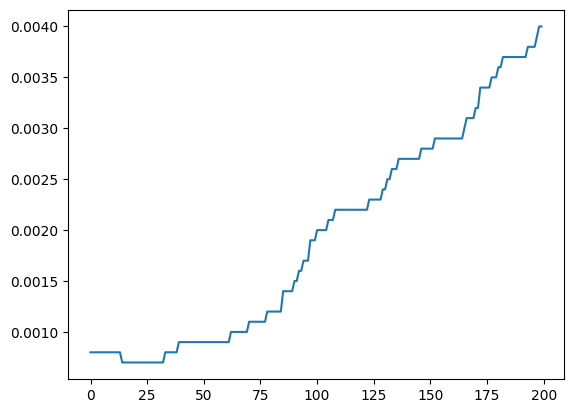

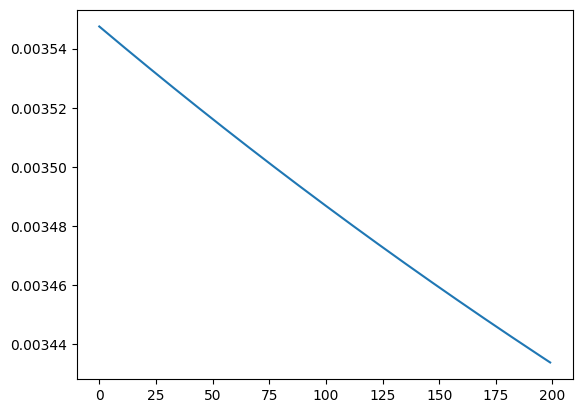

epoch: 1, Validation accuracy = 0.0007
epoch: 21, Validation accuracy = 0.0010
epoch: 41, Validation accuracy = 0.0012
epoch: 61, Validation accuracy = 0.0015
epoch: 81, Validation accuracy = 0.0017
epoch: 101, Validation accuracy = 0.0019
epoch: 121, Validation accuracy = 0.0021
epoch: 141, Validation accuracy = 0.0023
epoch: 161, Validation accuracy = 0.0027
epoch: 181, Validation accuracy = 0.0030
Test accuracy WordContent, on random dimensions: 0.0046


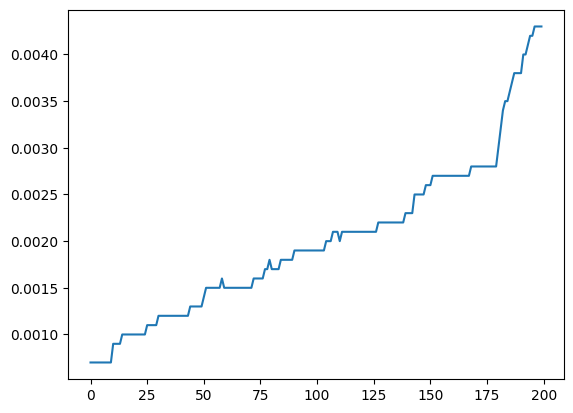

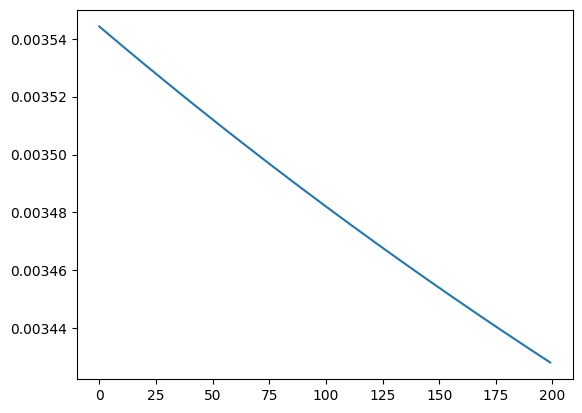

epoch: 1, Validation accuracy = 0.0012
epoch: 21, Validation accuracy = 0.0012
epoch: 41, Validation accuracy = 0.0013
epoch: 61, Validation accuracy = 0.0014
epoch: 81, Validation accuracy = 0.0016
epoch: 101, Validation accuracy = 0.0020
epoch: 121, Validation accuracy = 0.0022
epoch: 141, Validation accuracy = 0.0026
epoch: 161, Validation accuracy = 0.0030
epoch: 181, Validation accuracy = 0.0031
Test accuracy WordContent, on random dimensions: 0.0037


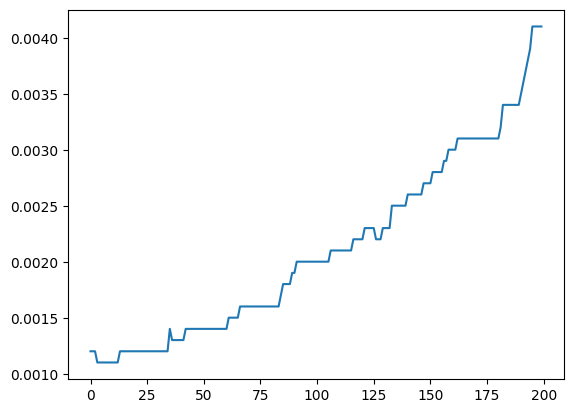

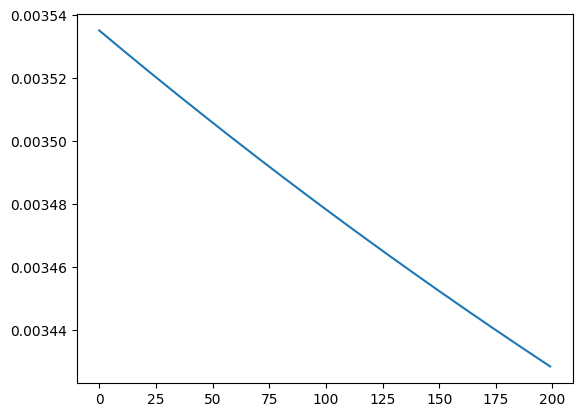

epoch: 1, Validation accuracy = 0.0012
epoch: 21, Validation accuracy = 0.0015
epoch: 41, Validation accuracy = 0.0021
epoch: 61, Validation accuracy = 0.0027
epoch: 81, Validation accuracy = 0.0029
epoch: 101, Validation accuracy = 0.0034
epoch: 121, Validation accuracy = 0.0043
epoch: 141, Validation accuracy = 0.0046
epoch: 161, Validation accuracy = 0.0046
epoch: 181, Validation accuracy = 0.0050
Test accuracy WordContent, on random dimensions: 0.0043


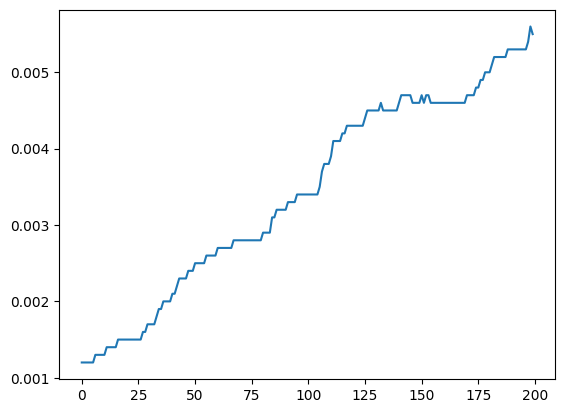

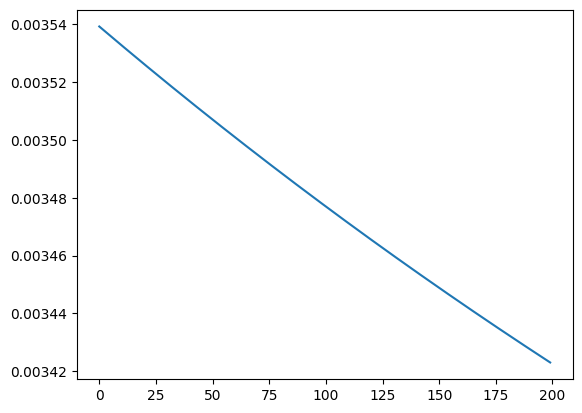

{'Length': 0.7732092837134854,
 'Depth': 0.3826,
 'TopConstituents': 0.7269,
 'BigramShift': 0.9024,
 'Tense': 0.8836,
 'SubjNumber': 0.8542,
 'ObjNumber': 0.8314,
 'OddManOut': 0.6859,
 'CoordinationInversion': 0.7140571885622875,
 'WordContent': 0.4506}

In [7]:
for transfer_task in transfer_tasks:
    all_accuracy[transfer_task], outlier_accuracy[transfer_task], random_accuracy[transfer_task] = get_accuracies(transfer_task,
                                                                                                                  num_epochs=num_epochs,
                                                                                                                  batch_size=batch_size,
                                                                                                                  lr=lr,
                                                                                                                  outlier_dimensions=outlier_dimensions)
all_accuracy

<ipython-input-8-35abe10aadff>:20: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


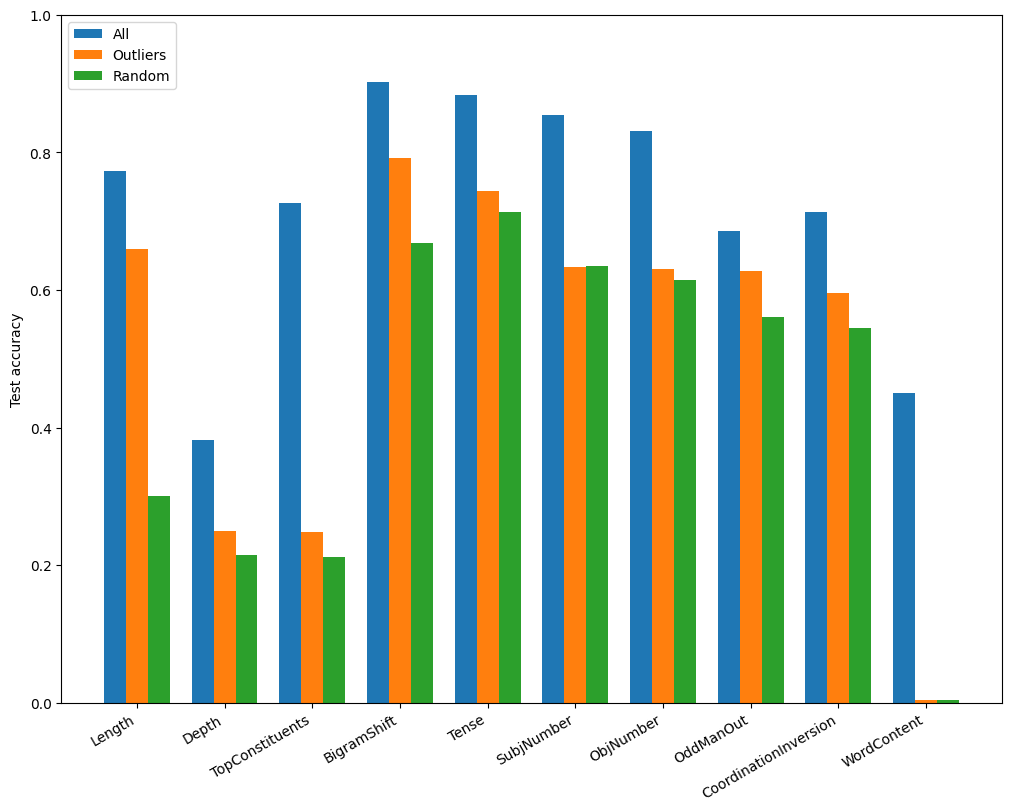

In [8]:
x = np.arange(len(transfer_tasks))
all_acc, outlier_acc, random_acc = [], [], []
for task in transfer_tasks:
    all_acc.append(all_accuracy[task])
    outlier_acc.append(outlier_accuracy[task])
    random_acc.append(random_accuracy[task])
accuracies = {"All": all_acc, "Outliers": outlier_acc, "Random": random_acc}
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10, 8))

for attribute, measurement in accuracies.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_ylabel('Test accuracy')
ax.set_xticks(x + width, transfer_tasks)
fig.autofmt_xdate()
ax.legend(loc='upper left')
ax.set_ylim(0, 1)
plt.show()
fig.savefig('Test_accuracy.png')